# Predicting MGUS evolving in MM - Feature Engineering

# Preprocessing and preliminary operations

This is the reviewed code implementing rfe on a subset of features selected through mrmr algorithm. Unbalance is addressed with SMOTE so that the number of samples in each class is equal and results will not be that much compromised if we preserve a part of data to be used as validation and test set. Because of some problems with mrmr requirements I suggest to run the notebook using the Python 3.11.5 kernel.

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import EditedNearestNeighbours
from sklearn.model_selection import train_test_split, LeaveOneOut, GridSearchCV, cross_val_score, KFold
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectKBest
from sklearn.metrics import mean_squared_error, accuracy_score, recall_score, precision_score, classification_report, confusion_matrix, make_scorer, f1_score
from sklearn.linear_model import Lasso, LogisticRegression, RidgeClassifier, ElasticNet
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier

In [2]:
from MLMethods.feature_selection.mRMR import mRMR

In [3]:
train_data = pd.read_csv("gene_expr_label.csv", index_col=0)

In [4]:
X = train_data.drop('state', axis=1)
y = train_data['state']

In [5]:
LOO = False
SCALE = True

In [6]:
def scale(data):
    # Inizializza lo StandardScaler e applica lo z-score allo stesso tempo
    scaler = StandardScaler()
    X = data.drop('state', axis=1)
    y = data['state']
    columns = X.columns
    X = scaler.fit_transform(X)
    train_data = pd.DataFrame(X, columns=columns)
    train_data['state'] = np.array(y)
    X = train_data.drop('state', axis=1)
    y = train_data['state']
    return train_data, X, y

if SCALE:
    train_data, X, y = scale(train_data)

In [7]:
if not LOO:
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
    X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, test_size=0.5, random_state=42, stratify=y_test)
else:
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42, stratify=y)

In [8]:
with open('probe_genes.txt', 'r') as f:
    probe_genes = f.read().splitlines()

Split data in train, validation and test sets

In [9]:
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42, stratify=y)

In [10]:
if 'experiments' not in globals():
    columns = ['SCALE', 'RVOS', 'SMOTED', 'LOO', 'CLASSIFIER', 'ACCURACY', 'F1', 'PRECISION', 'RECALL']  # Sostituisci con i nomi delle colonne desiderate
    experiments = pd.DataFrame(columns=columns)

def get_metrics(true_labels, predictions):
    accuracy = accuracy_score(true_labels, predictions)
    f1 = f1_score(true_labels, predictions)
    recall = recall_score(true_labels, predictions)
    precision = precision_score(true_labels, predictions)
    return [accuracy, f1, precision, recall]
# Funzione per controllare se una riga è già presente nel DataFrame
def add_exp(true_labels, predictions):
    columns = ['SCALE', 'RVOS', 'SMOTED', 'LOO', 'CLASSIFIER', 'ACCURACY', 'F1', 'PRECISION', 'RECALL']
    exp = pd.Series([*[SCALE, RVOS, SMOTED, LOO, clf] + get_metrics(true_labels, predictions)], index=columns)
    print(exp)
    experiments.loc[len(experiments)] = exp

## Addressing unbalance

Perform ENN and SMOTE combining undersampling and oversampling to improve generalization, prevent overfitting and also avoid excessive distorsion of minority class

In [11]:
SMOTED = False
RVOS = True
LOO = False
CV = True


In [12]:
import random

In [13]:
def smote_enn(X_train, y_train):
    enn = EditedNearestNeighbours()
    X_train, y_train = enn.fit_resample(X_train, y_train)
    smote = SMOTE(random_state=42)
    X_train, y_train  = smote.fit_resample(X_train, y_train )
    return X_train, y_train

In [137]:

def rvos(X_train,y_train):
    # Transform df in arrays
    # Split in two class
    stable = np.array(X_train[y_train == 0])
    progressing = np.array(X_train[y_train == 1])
    m_1,n_1=progressing.shape
    m_0,n_0=stable.shape
    progressing = progressing.tolist()
    stable = stable.tolist()
    dataset_generated=[]
    count=m_0-m_1
    while count:
        sample = []
        for j in range(n_1):
            # Seleziona un valore da campione casuale della classe di minoranza e lo aggiunge ai campioni sintetici
            element = progressing[random.randint(0,m_1-1)][j]
            sample.append(element)
        dataset_generated.append(sample)
        count-=1
    # Aggiungo dati generati a quelli esistenti
    progressing.extend(dataset_generated)
    # Trasformo in df e aggiungo label 'state'
    progressing = pd.DataFrame(progressing, columns=X_train.columns)
    stable = pd.DataFrame(stable, columns = X_train.columns)
    progressing['state'] = 1
    stable['state'] = 0
    # Concateno e shuffle
    balanced_df = pd.concat([stable, progressing], axis=0)
    balanced_df = balanced_df.sample(frac=1, random_state=42).reset_index(drop=True)
    # Riporto a nomenclatura in uso 
    X_train = balanced_df.drop(columns='state')
    y_train = balanced_df['state']
    return X_train, y_train


## Functions to train and validate

In [15]:
def train_validate(clf, n):
    if LOO:
        predictions = []
        true_labels = []
        indexes_1 = list(X_train[y_train==1].index)
        indexes_0 = random.sample(list(X_train[y_train==0].index), n)
        indexes = indexes_0 + indexes_1
        # Ripeti il processo per un totale di 70 volte
        for i in range(len(indexes)):  # Numero di iterazioni per ogni classe
            # Suddivide il dataset di addestramento in set di addestramento e di test
            X_train_fold, X_test_fold = X_train.loc[X_train.index[~(X_train.index == indexes[i])]], X_train.loc[indexes[i]]
            y_train_fold, y_test_fold = y_train[y_train.index[~(y_train.index == indexes[i])]], y_train.loc[indexes[i]]
            
            if RVOS:
                X_train_fold, y_train_fold = rvos(X_train_fold, y_train_fold)
            if SMOTED:
                X_train_fold, y_train_fold = smote_enn(X_train_fold, y_train_fold)
            
            # Addestra il classificatore sul set di addestramento corrente
            clf.fit(X_train_fold, y_train_fold)
            y_pred = clf.predict(np.array(X_test_fold).reshape(1, -1))
            # Aggiungi le previsioni e le etichette di test alle liste
            predictions.append(*y_pred)
            true_labels.append(y_test_fold)
            
        # Calcola e stampa le metriche di valutazione finali
        print("Classification Report:")
        print(classification_report(true_labels, predictions))
        print("Confusion Matrix:")
        print(confusion_matrix(true_labels, predictions))
        get_metrics(true_labels, predictions)
        add_exp(true_labels, predictions)
        
    if not LOO:
        predictions = []
        true_labels = []
        num_folds = 5
        kf = KFold(n_splits=num_folds)
        for train_index, val_index in kf.split(X_train):
            X_train_fold, X_val_fold = X_train.iloc[train_index], X_train.iloc[val_index]
            y_train_fold, y_val_fold = y_train.iloc[train_index], y_train.iloc[val_index]
            if RVOS:
                X_train_fold, y_train_fold = rvos(X_train_fold, y_train_fold)
            if SMOTED:
                X_train_fold, y_train_fold = smote_enn(X_train_fold, y_train_fold)
            clf.fit(X_train_fold, y_train_fold)
            y_pred = clf.predict(X_val_fold)
            predictions.extend(y_pred)
            true_labels.extend(y_val_fold)

        # Calcola e stampa le metriche di valutazione finali sull'intero dataset di validazione
        print("Classification Report sull'intero dataset di validazione:")
        print(classification_report(true_labels, predictions))
        print("Confusion Matrix sull'intero dataset di validazione:")
        print(confusion_matrix(true_labels, predictions))
        print(get_metrics(true_labels, predictions))
        get_metrics(true_labels, predictions)
        add_exp(true_labels, predictions)

In [16]:
def reset_data():
    global X_train, X_test, X_val, y_train, y_test, y_val
    train_data = pd.read_csv("gene_expr_label.csv", index_col=0)
    X = train_data.drop('state', axis=1)
    y = train_data['state']
    if SCALE:
        train_data, X, y = scale(train_data)
    if not LOO:
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
        X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, test_size=0.5, random_state=42, stratify=y_test)
    else:
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42, stratify=y)

In [17]:
DISCRETIZATION = True
def discretize(X_train):
    mean = X_train.mean()
    std = X_train.std()
    over_expressed = mean + std/2
    under_expressed = mean - std/2
    X_train_discrete = X_train.mask((X_train > over_expressed), 2)
    X_train_discrete = X_train_discrete.mask((X_train < under_expressed), -2)
    X_train_discrete = X_train_discrete.mask(((X_train_discrete != 2) & (X_train_discrete != -2)), 0)
    return X_train_discrete

## Experiments with whole features set

This part is only needed to understand which model could we adopt further as estimator and to get very vague intuitions about suitable hyperparameters

In [18]:
for c in [0.1, 0.3, 0.5, 0.7, 0.9]:
    clf = LogisticRegression(penalty='l1', C=c, solver='liblinear')
    train_validate(clf, c)

KeyboardInterrupt: 

In [ ]:
experiments

,SCALE,RVOS,SMOTED,LOO,CLASSIFIER,ACCURACY,F1,PRECISION,RECALL
0,False,True,False,False,"LogisticRegression(C=0.1, penalty='l1', solver...",0.807692,0.367816,0.285714,0.516129
1,False,True,False,False,"LogisticRegression(C=0.3, penalty='l1', solver...",0.835664,0.253968,0.25,0.258065
2,False,True,False,False,"LogisticRegression(C=0.5, penalty='l1', solver...",0.835664,0.276923,0.264706,0.290323
3,False,True,False,False,"LogisticRegression(C=0.7, penalty='l1', solver...",0.84965,0.295082,0.3,0.290323
4,False,True,False,False,"LogisticRegression(C=0.9, penalty='l1', solver...",0.853147,0.222222,0.26087,0.193548
5,False,True,False,False,RidgeClassifier(alpha=0.5),0.881119,0.105263,0.285714,0.064516
6,False,True,False,False,KNeighborsClassifier(n_neighbors=4),0.891608,0.0,0.0,0.0
7,False,True,False,False,"SVC(C=0.1, kernel='linear')",0.877622,0.186047,0.333333,0.129032
8,False,True,False,False,"SVC(C=0.3, kernel='linear')",0.877622,0.186047,0.333333,0.129032
9,False,True,False,False,"SVC(C=0.5, kernel='linear')",0.877622,0.186047,0.333333,0.129032


In [ ]:
reset_data()

In [ ]:
clf = RidgeClassifier(alpha=0.5, fit_intercept=True)
train_validate(clf, 0)

Classification Report sull'intero dataset di validazione:
              precision    recall  f1-score   support

           0       0.90      0.98      0.94       255
           1       0.29      0.06      0.11        31

    accuracy                           0.88       286
   macro avg       0.59      0.52      0.52       286
weighted avg       0.83      0.88      0.85       286

Confusion Matrix sull'intero dataset di validazione:
[[250   5]
 [ 29   2]]
SCALE                              False
RVOS                                True
SMOTED                             False
LOO                                False
CLASSIFIER    RidgeClassifier(alpha=0.5)
ACCURACY                        0.881119
F1                              0.105263
PRECISION                       0.285714
RECALL                          0.064516
dtype: object


In [ ]:
reset_data()

In [ ]:
clf = KNeighborsClassifier(n_neighbors=4)  # Imposta il numero di vicini (k) a 5, puoi regolarlo a tuo piacimento
train_validate(clf, 0)

Classification Report sull'intero dataset di validazione:
              precision    recall  f1-score   support

           0       0.89      1.00      0.94       255
           1       0.00      0.00      0.00        31

    accuracy                           0.89       286
   macro avg       0.45      0.50      0.47       286
weighted avg       0.79      0.89      0.84       286

Confusion Matrix sull'intero dataset di validazione:
[[255   0]
 [ 31   0]]
[0.8916083916083916, 0.0, 0.0, 0.0]
SCALE                                        True
RVOS                                         True
SMOTED                                      False
LOO                                         False
CLASSIFIER    KNeighborsClassifier(n_neighbors=4)
ACCURACY                                 0.891608
F1                                            0.0
PRECISION                                     0.0
RECALL                                        0.0
dtype: object


/Users/mirea199/computational-health-laboratory/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/mirea199/computational-health-laboratory/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/mirea199/computational-health-laboratory/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavi

In [ ]:
reset_data()
for c in [0.1, 0.3, 0.5, 0.7, 0.9]:
    clf = SVC(C=c, kernel='linear')
    train_validate(clf, 0)

Classification Report sull'intero dataset di validazione:
              precision    recall  f1-score   support

           0       0.90      0.97      0.93       255
           1       0.33      0.13      0.19        31

    accuracy                           0.88       286
   macro avg       0.62      0.55      0.56       286
weighted avg       0.84      0.88      0.85       286

Confusion Matrix sull'intero dataset di validazione:
[[247   8]
 [ 27   4]]
SCALE                               False
RVOS                                 True
SMOTED                              False
LOO                                 False
CLASSIFIER    SVC(C=0.1, kernel='linear')
ACCURACY                         0.877622
F1                               0.186047
PRECISION                        0.333333
RECALL                           0.129032
dtype: object
Classification Report sull'intero dataset di validazione:
              precision    recall  f1-score   support

           0       0.90      0.97 

In [ ]:
reset_data()

In [ ]:
# Definisci il modello Random Forest
clf = RandomForestClassifier(n_estimators=400, random_state=42)
train_validate(clf, 0)

Classification Report sull'intero dataset di validazione:
              precision    recall  f1-score   support

           0       0.90      0.98      0.94       255
           1       0.50      0.13      0.21        31

    accuracy                           0.89       286
   macro avg       0.70      0.56      0.57       286
weighted avg       0.86      0.89      0.86       286

Confusion Matrix sull'intero dataset di validazione:
[[251   4]
 [ 27   4]]
SCALE                                                     False
RVOS                                                       True
SMOTED                                                    False
LOO                                                       False
CLASSIFIER    (DecisionTreeClassifier(max_features='sqrt', r...
ACCURACY                                               0.891608
F1                                                     0.205128
PRECISION                                                   0.5
RECALL                     

In [ ]:
experiments

,SCALE,RVOS,SMOTED,LOO,CLASSIFIER,ACCURACY,F1,PRECISION,RECALL
0,False,True,False,False,"LogisticRegression(C=0.1, penalty='l1', solver...",0.807692,0.367816,0.285714,0.516129
1,False,True,False,False,"LogisticRegression(C=0.3, penalty='l1', solver...",0.835664,0.253968,0.25,0.258065
2,False,True,False,False,"LogisticRegression(C=0.5, penalty='l1', solver...",0.835664,0.276923,0.264706,0.290323
3,False,True,False,False,"LogisticRegression(C=0.7, penalty='l1', solver...",0.84965,0.295082,0.3,0.290323
4,False,True,False,False,"LogisticRegression(C=0.9, penalty='l1', solver...",0.853147,0.222222,0.26087,0.193548
5,False,True,False,False,RidgeClassifier(alpha=0.5),0.881119,0.105263,0.285714,0.064516
6,False,True,False,False,KNeighborsClassifier(n_neighbors=4),0.891608,0.0,0.0,0.0
7,False,True,False,False,"SVC(C=0.1, kernel='linear')",0.877622,0.186047,0.333333,0.129032
8,False,True,False,False,"SVC(C=0.3, kernel='linear')",0.877622,0.186047,0.333333,0.129032
9,False,True,False,False,"SVC(C=0.5, kernel='linear')",0.877622,0.186047,0.333333,0.129032


In [ ]:
clf = LogisticRegression(penalty = 'elasticnet', solver = 'saga', l1_ratio = 0.5)
train_validate(clf, 0)

/Users/mirea199/computational-health-laboratory/venv/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/mirea199/computational-health-laboratory/venv/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/mirea199/computational-health-laboratory/venv/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/mirea199/computational-health-laboratory/venv/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/mirea199/computational-health-laboratory/venv/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: T

Classification Report sull'intero dataset di validazione:
              precision    recall  f1-score   support

           0       0.97      0.22      0.36       255
           1       0.13      0.94      0.22        31

    accuracy                           0.30       286
   macro avg       0.55      0.58      0.29       286
weighted avg       0.88      0.30      0.35       286

Confusion Matrix sull'intero dataset di validazione:
[[ 57 198]
 [  2  29]]
[0.3006993006993007, 0.2248062015503876, 0.1277533039647577, 0.9354838709677419]
SCALE                                                      True
RVOS                                                       True
SMOTED                                                    False
LOO                                                       False
CLASSIFIER    LogisticRegression(l1_ratio=0.5, penalty='elas...
ACCURACY                                               0.300699
F1                                                     0.224806
PRECISION 

In [ ]:
experiments

,SCALE,RVOS,SMOTED,LOO,CLASSIFIER,ACCURACY,F1,PRECISION,RECALL
0,False,True,False,False,"LogisticRegression(C=0.1, penalty='l1', solver...",0.807692,0.367816,0.285714,0.516129
1,False,True,False,False,"LogisticRegression(C=0.3, penalty='l1', solver...",0.835664,0.253968,0.25,0.258065
2,False,True,False,False,"LogisticRegression(C=0.5, penalty='l1', solver...",0.835664,0.276923,0.264706,0.290323
3,False,True,False,False,"LogisticRegression(C=0.7, penalty='l1', solver...",0.84965,0.295082,0.3,0.290323
4,False,True,False,False,"LogisticRegression(C=0.9, penalty='l1', solver...",0.853147,0.222222,0.26087,0.193548
5,False,True,False,False,RidgeClassifier(alpha=0.5),0.881119,0.105263,0.285714,0.064516
6,False,True,False,False,KNeighborsClassifier(n_neighbors=4),0.891608,0.0,0.0,0.0
7,False,True,False,False,"SVC(C=0.1, kernel='linear')",0.877622,0.186047,0.333333,0.129032
8,False,True,False,False,"SVC(C=0.3, kernel='linear')",0.877622,0.186047,0.333333,0.129032
9,False,True,False,False,"SVC(C=0.5, kernel='linear')",0.877622,0.186047,0.333333,0.129032


Conclusions: Suitable choices are SVC and Logistic Regression. Distance based classifiers seems not to be the best choice.

# rMRM based on combination of linear shannon information terms

This feature selected method works similarly to classic mrmr but doesn't require the specification of 2 metrics (one for redundancy and one for relevance) since it relies on a linear combination of Shannon information terms. Reference:
https://www.jmlr.org/papers/volume13/brown12a/brown12a.pdf

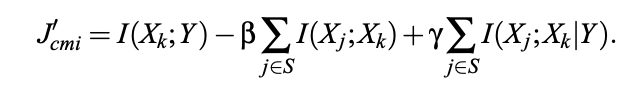

In [19]:
reset_data()
X_train, y_train = rvos(X_train, y_train)

In [20]:
def mRMR(n_genes):
    f=LCSI.lcsi(np.array(X_train), np.array(y_train), function_name="MRMR",n_selected_features=n_genes,gamma=0)
    newdata=X_train[:,f]
    return newdata

In [21]:
mrmr_data = mRMR(200)
# Cell crashed but indexes had been outputted

KeyboardInterrupt: 

In [140]:
mrmr_shannon_selected = [0, 30932, 30952, 20760, 34053, 24131, 24673, 23973, 24415,
       23965, 18552, 22803, 17224, 50758, 10940, 22174, 21279, 18271,
       22883, 14341, 15762, 25523, 46245, 12461, 23788, 39229, 42172,
       18249, 39204, 23189,  4850, 48575, 20639, 51391, 48585,   975,
       43569, 48349, 52729, 18691,  9251, 52578, 26312,  4362, 41978,
        2116,  8774, 29525,  8676, 26187, 25535, 12654,  1810,  3663,
       46942,   337, 46367, 42759, 17144, 13384, 11339, 42223, 44538,
       16411, 40819, 46202, 51549,  7820,  9804, 22533, 21041,  6102,
       23856, 21883, 37092,  4047, 19012, 50120, 26917, 19523,  2227,
         383, 30827, 26339,   979, 54645, 36392, 11070, 18240, 42512,
       20031, 21531,  8597,   640, 40104, 50859, 16919, 21290, 50176,
       26381, 26936,  1616,  5370, 18881, 29544, 43076,  7302, 28828,
        2039,  8023, 25811, 38907, 29728, 32472,  9972, 51871,  1837,
       36718, 50306, 23539, 11560, 28960, 41562, 40991, 52489, 25866,
       30531, 33229, 11792, 22731, 48913, 31283, 45821,  2127, 24198,
       33259, 41886, 39649, 43804, 36154, 25239, 45687, 44584, 47350,
       48946,  5792, 33375, 23401,  9141, 44600, 23460, 43105, 22439,
       53912, 48663,  2804,  8775, 42900, 24864, 10643, 41211, 23895,
       25688, 17512, 10397, 47719, 11995, 26040, 45822, 15553,  6837,
       12845, 22499, 22076, 19227,  6709, 10187, 14936, 52812,  6730,
       19432,  3849, 26886, 50260, 50167, 45051,  8235, 33176, 33093,
       15592, 21004,  6194,  7094,  7304,  9699,  5482, 52339, 13012,
         578,  7157]

In [97]:
reset_data()

In [99]:
X_train_reduced = X_train.iloc[:,mrmr_shannon_selected]
X_train = X_train_reduced

In [101]:
X_train_ov, y_train_ov = rvos(X_train, y_train)

In [103]:
clf = LogisticRegression(C=0.5, solver='saga', penalty='elasticnet', l1_ratio=0.7)
clf.fit(X_train_ov, y_train_ov)
y_pred = clf.predict(X_val.iloc[:,mrmr_shannon_selected])
print(classification_report(y_val, y_pred))
print(confusion_matrix(y_val, y_pred))

              precision    recall  f1-score   support

           0       0.96      0.84      0.90        32
           1       0.38      0.75      0.50         4

    accuracy                           0.83        36
   macro avg       0.67      0.80      0.70        36
weighted avg       0.90      0.83      0.86        36

[[27  5]
 [ 1  3]]


In [104]:
clf = LogisticRegression(C=0.5, penalty='l1', solver='liblinear')
clf.fit(X_train_ov, y_train_ov)
y_pred = clf.predict(X_val.iloc[:,mrmr_shannon_selected])
print(classification_report(y_val, y_pred))
print(confusion_matrix(y_val, y_pred))

              precision    recall  f1-score   support

           0       0.97      0.88      0.92        32
           1       0.43      0.75      0.55         4

    accuracy                           0.86        36
   macro avg       0.70      0.81      0.73        36
weighted avg       0.91      0.86      0.88        36

[[28  4]
 [ 1  3]]


In [107]:
clf = LogisticRegression(C=0.5, solver='liblinear', penalty='l1', class_weight=class_weight_dict)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_val.iloc[:,mrmr_shannon_selected])
print(classification_report(y_val, y_pred))
print(confusion_matrix(y_val, y_pred))

              precision    recall  f1-score   support

           0       0.97      0.88      0.92        32
           1       0.43      0.75      0.55         4

    accuracy                           0.86        36
   macro avg       0.70      0.81      0.73        36
weighted avg       0.91      0.86      0.88        36

[[28  4]
 [ 1  3]]


In [133]:
clf = LogisticRegression(C=0.5, solver='saga', penalty='elasticnet', l1_ratio=0.7)
train_validate(clf, 0)

Classification Report sull'intero dataset di validazione:
              precision    recall  f1-score   support

           0       0.92      0.83      0.87       255
           1       0.21      0.39      0.28        31

    accuracy                           0.78       286
   macro avg       0.57      0.61      0.57       286
weighted avg       0.84      0.78      0.81       286

Confusion Matrix sull'intero dataset di validazione:
[[211  44]
 [ 19  12]]
[0.7797202797202797, 0.2758620689655172, 0.21428571428571427, 0.3870967741935484]
SCALE                                                      True
RVOS                                                       True
SMOTED                                                    False
LOO                                                       False
CLASSIFIER    LogisticRegression(C=0.5, l1_ratio=0.7, penalt...
ACCURACY                                                0.77972
F1                                                     0.275862
PRECISION

In [116]:
clf = LogisticRegression(C=0.5, penalty='l1', solver='liblinear')
train_validate(clf, 0)

Classification Report sull'intero dataset di validazione:
              precision    recall  f1-score   support

           0       0.92      0.88      0.90       255
           1       0.26      0.35      0.30        31

    accuracy                           0.82       286
   macro avg       0.59      0.62      0.60       286
weighted avg       0.85      0.82      0.83       286

Confusion Matrix sull'intero dataset di validazione:
[[224  31]
 [ 20  11]]
[0.8216783216783217, 0.3013698630136986, 0.2619047619047619, 0.3548387096774194]
SCALE                                                      True
RVOS                                                       True
SMOTED                                                    False
LOO                                                       False
CLASSIFIER    LogisticRegression(C=0.5, penalty='l1', solver...
ACCURACY                                               0.821678
F1                                                      0.30137
PRECISION 

In [117]:
experiments

,SCALE,RVOS,SMOTED,LOO,CLASSIFIER,ACCURACY,F1,PRECISION,RECALL
0,True,True,False,False,"LogisticRegression(C=0.5, l1_ratio=0.7, penalt...",0.891608,0.626506,0.5,0.83871
1,True,False,False,False,"LogisticRegression(C=0.5,\n ...",0.804196,0.243243,0.209302,0.290323
2,True,True,False,False,"LogisticRegression(C=0.5,\n ...",0.716783,0.213592,0.152778,0.354839
3,True,True,False,False,"LogisticRegression(C=0.5, penalty='l1', solver...",0.811189,0.228571,0.205128,0.258065
4,True,True,False,False,"LogisticRegression(C=0.5, l1_ratio=0.7, penalt...",0.783217,0.27907,0.218182,0.387097
5,True,True,False,False,"LogisticRegression(C=0.5, penalty='l1', solver...",0.821678,0.30137,0.261905,0.354839


In [706]:
with open('mrmr_200_miq.txt', 'w+') as file:
    for f in features_mrmr:
        file.write(str(f) + '\n')
with open('experiments.csv', 'w+') as file:
    file.write(experiments.to_csv())

# mRMR based on correlation and f-statistic

In [31]:
X_train

,1007_s_at,1053_at,117_at,121_at,1255_g_at,1294_at,1316_at,1320_at,1405_i_at,1431_at,...,AFFX-r2-Ec-bioD-3_at,AFFX-r2-Ec-bioD-5_at,AFFX-r2-P1-cre-3_at,AFFX-r2-P1-cre-5_at,AFFX-ThrX-3_at,AFFX-ThrX-5_at,AFFX-ThrX-M_at,AFFX-TrpnX-3_at,AFFX-TrpnX-5_at,AFFX-TrpnX-M_at
0,-1.493030,-0.437761,-1.553721,1.752360,-0.187331,1.301766,0.059784,1.732421,0.708038,-1.199879,...,-0.497011,-3.203222,-0.650559,1.103115,-0.698685,0.070375,-0.327075,0.345951,-0.741957,-0.671449
1,-0.313207,-0.952335,-0.597749,0.645205,-0.605604,0.214755,-1.552062,-0.440492,-0.989278,0.240431,...,-0.205394,0.647545,-0.596701,-0.798314,-0.497558,3.084909,-0.571470,1.011108,-0.337838,-2.153621
2,1.598403,-1.172125,0.237330,-0.103610,1.385505,-2.802954,-1.043368,-0.318931,-1.097678,0.231993,...,-0.857072,-0.509851,-2.476272,-1.875436,-0.364004,-0.459101,-0.362060,-0.134083,-0.707955,-1.377894
3,1.361098,0.333841,-0.414786,-0.212895,-0.112049,-0.135387,-0.339205,0.394762,-0.032231,0.646893,...,-1.804309,-0.514663,0.331545,-0.006873,-0.273519,2.867549,-0.374980,-1.002729,-1.759664,2.220115
4,-0.078696,-0.317740,-0.249500,-1.075059,-0.112049,-1.399952,-1.504473,1.422425,1.185707,-0.414547,...,0.278223,-2.020054,-1.302161,-1.147243,-0.569363,-0.388171,-0.448342,-0.012399,-0.046843,0.628691
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
505,-1.326209,-1.635461,0.052754,0.175108,0.062659,-0.177779,0.792237,1.077572,-1.092950,-0.612260,...,1.002752,1.234357,0.817020,1.005816,-0.281253,-0.901628,-0.485915,0.875387,0.845766,2.126901
506,-0.194111,0.591942,-0.073125,-1.411354,-0.621264,1.684463,-0.555874,0.203131,1.661570,-1.333472,...,-0.703661,-0.713340,-0.663572,-0.917820,-0.376810,-0.459101,-0.235151,0.669538,-0.493680,-0.552467
507,-1.027733,-2.128700,0.271470,-0.103610,0.216059,-2.682433,-0.555874,0.266400,-0.969039,-2.299474,...,-2.532079,-1.720359,-2.458049,0.043108,-0.411206,-0.338754,-0.529324,-0.012399,-1.971192,1.752437
508,-2.106517,0.034855,0.271470,-0.167590,-0.387228,-2.682433,-1.504473,0.266400,-0.969039,-0.528560,...,0.278223,-1.647100,-0.127354,-0.819431,-0.411206,-0.418208,-0.364107,0.298020,0.009897,2.220115


In [62]:
import mrmr
from mrmr.pandas import mrmr_classif


In [65]:
selected_features = mrmr_classif(X=X_train, y=y_train, K=300)

100%|██████████| 300/300 [1:01:31<00:00, 12.31s/it]


In [66]:
mrmr_corr_f_selected = selected_features

In [71]:
with open("mrmr_fs/mrmr_corr_f_selected", "w") as file:
    # Write each gene to the file
    for gene in mrmr_corr_f_selected:
        file.write(gene + "\n")

In [72]:
with open('probe_genes.txt', 'r') as f:
    prob_genes = [line.strip() for line in f.readlines()]

In [73]:
intersezione = list(set(prob_genes) & set(mrmr_corr_f_selected))
len(intersezione)

9

In [78]:
reset_data()

In [81]:
X_train = X_train[mrmr_corr_f_selected]

In [82]:
X_train

,216829_at,1556284_at,1559433_at,202389_s_at,229491_at,216573_at,234419_x_at,218199_s_at,226882_x_at,225822_at,...,242719_at,218964_at,1564155_x_at,224955_at,232692_at,217369_at,206553_at,212316_at,243165_at,210755_at
22,-0.016116,-0.782964,-0.629114,-1.035004,0.866951,-1.019966,-0.935140,0.519139,0.513205,0.027275,...,-0.440848,1.324573,0.002159,-0.754174,0.660409,-0.940944,-0.062574,1.981520,1.409929,-1.910487
285,1.197519,-0.201221,0.106991,-1.182721,-0.111820,1.349349,0.927879,-1.418331,0.219763,0.018008,...,-2.086055,-0.326353,1.111974,0.244041,-0.708889,1.235897,-0.524706,-0.886598,-0.018033,-1.034326
183,-1.374193,2.034180,3.433185,1.245098,1.573233,-1.024037,0.470072,-0.404291,0.418837,0.059203,...,-0.404566,0.004251,-2.047042,1.857187,0.868763,0.257271,0.524809,0.638916,0.280223,0.989447
10,0.699512,-1.641525,0.129762,-0.229405,-1.653090,-0.044840,0.711181,0.207281,-0.135633,-0.790421,...,-0.987398,0.533520,-0.145246,-0.388948,1.858849,1.638576,-0.141277,-0.815592,-0.225402,0.187420
308,0.759503,0.163427,0.120812,-0.703194,0.041078,0.918830,0.295484,0.106199,0.487310,-0.735990,...,-1.306287,-1.136427,0.729255,-1.102184,-1.584617,0.436041,0.073401,-0.085330,-0.607848,-0.789937
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
148,0.815249,0.054050,-0.467689,-1.149988,-0.312179,1.162030,0.509282,-1.252371,-1.150380,-0.045858,...,0.770905,-0.881737,0.646978,-0.072373,-0.640695,-0.327432,-0.644853,0.252529,-0.610977,-0.066697
331,0.457015,-1.247179,1.088324,-1.468928,-0.133152,0.624697,0.107244,0.253510,-0.728066,0.104182,...,0.358413,0.925264,-0.220373,0.028874,1.423711,0.638434,0.297305,-0.378391,0.463029,-0.434077
238,0.709510,-0.186416,0.596602,0.925345,-1.091896,0.776802,0.459105,-0.280786,0.313783,0.269667,...,-1.877410,-0.335184,0.184958,0.007480,-0.638026,0.069564,-1.938048,-0.164563,-0.206098,0.959062
193,0.096787,0.744277,1.644694,1.341018,0.668604,0.973965,1.150328,0.276461,2.218443,1.954841,...,0.508454,-0.046694,1.531036,-0.035947,1.586351,0.785604,0.817366,0.584365,1.387992,0.642261


In [83]:
clf = LogisticRegression(C=0.5, solver='saga', penalty='elasticnet', l1_ratio=0.7)
train_validate(clf, 0)

Classification Report sull'intero dataset di validazione:
              precision    recall  f1-score   support

           0       0.98      0.90      0.94       255
           1       0.50      0.84      0.63        31

    accuracy                           0.89       286
   macro avg       0.74      0.87      0.78       286
weighted avg       0.93      0.89      0.90       286

Confusion Matrix sull'intero dataset di validazione:
[[229  26]
 [  5  26]]
[0.8916083916083916, 0.6265060240963854, 0.5, 0.8387096774193549]
SCALE                                                      True
RVOS                                                       True
SMOTED                                                    False
LOO                                                       False
CLASSIFIER    LogisticRegression(C=0.5, l1_ratio=0.7, penalt...
ACCURACY                                               0.891608
F1                                                     0.626506
PRECISION                

In [85]:
X_train_ov, y_train_ov = rvos(X_train, y_train)

In [88]:
clf = LogisticRegression(C=0.5, solver='saga', penalty='elasticnet', l1_ratio=0.7)
clf.fit(X_train_ov, y_train_ov)
y_pred = clf.predict(X_val[mrmr_corr_f_selected])
print(classification_report(y_val, y_pred))
print(confusion_matrix(y_val, y_pred))

              precision    recall  f1-score   support

           0       0.97      0.88      0.92        32
           1       0.43      0.75      0.55         4

    accuracy                           0.86        36
   macro avg       0.70      0.81      0.73        36
weighted avg       0.91      0.86      0.88        36

[[28  4]
 [ 1  3]]


In [91]:
from sklearn.utils import class_weight, compute_class_weight
class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weight_dict = dict(enumerate(class_weights))

In [92]:
class_weight_dict

{0: 0.5607843137254902, 1: 4.612903225806452}

I was curious about training the LogReg on the unbalanced data. Weight are doing their wooooork :DDD

In [95]:
clf = LogisticRegression(C=0.5, solver='saga', penalty='elasticnet', l1_ratio=0.7, class_weight=class_weight_dict)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_val[mrmr_corr_f_selected])
print(classification_report(y_val, y_pred))
print(confusion_matrix(y_val, y_pred))

              precision    recall  f1-score   support

           0       0.97      0.88      0.92        32
           1       0.43      0.75      0.55         4

    accuracy                           0.86        36
   macro avg       0.70      0.81      0.73        36
weighted avg       0.91      0.86      0.88        36

[[28  4]
 [ 1  3]]


## Comparing MIQ and FSTAT extracted features

In [31]:
with open('mrmr_fs/mrmr_200_miq.txt', 'r') as f:
    mrmr_miq_indexes = [int(line.strip()) for line in f]

In [36]:
with open('mrmr_fs/mrmr_corr_f_selected', 'r') as f:
    mrmr_corr_f = [line.strip() for line in f]

In [37]:
with open('probe_genes.txt') as f:
    probe_genes = f.read().splitlines()

In [26]:
X_train.columns

Index(['1007_s_at', '1053_at', '117_at', '121_at', '1255_g_at', '1294_at',
       '1316_at', '1320_at', '1405_i_at', '1431_at',
       ...
       'AFFX-r2-Ec-bioD-3_at', 'AFFX-r2-Ec-bioD-5_at', 'AFFX-r2-P1-cre-3_at',
       'AFFX-r2-P1-cre-5_at', 'AFFX-ThrX-3_at', 'AFFX-ThrX-5_at',
       'AFFX-ThrX-M_at', 'AFFX-TrpnX-3_at', 'AFFX-TrpnX-5_at',
       'AFFX-TrpnX-M_at'],
      dtype='object', length=54675)

In [32]:
mrmr_miq = X_train.columns[mrmr_miq_indexes]

# RFE over MIQ selected

### Selector: Logistic Regression con solver lineare o saga elasticnet

The X_train used it is a scaled reduced train set based on miq features

In [ ]:
mrmr_shannon_selected

[0,
 30932,
 30952,
 20760,
 34053,
 24131,
 24673,
 23973,
 24415,
 23965,
 18552,
 22803,
 17224,
 50758,
 10940,
 22174,
 21279,
 18271,
 22883,
 14341,
 15762,
 25523,
 46245,
 12461,
 23788,
 39229,
 42172,
 18249,
 39204,
 23189,
 4850,
 48575,
 20639,
 51391,
 48585,
 975,
 43569,
 48349,
 52729,
 18691,
 9251,
 52578,
 26312,
 4362,
 41978,
 2116,
 8774,
 29525,
 8676,
 26187,
 25535,
 12654,
 1810,
 3663,
 46942,
 337,
 46367,
 42759,
 17144,
 13384,
 11339,
 42223,
 44538,
 16411,
 40819,
 46202,
 51549,
 7820,
 9804,
 22533,
 21041,
 6102,
 23856,
 21883,
 37092,
 4047,
 19012,
 50120,
 26917,
 19523,
 2227,
 383,
 30827,
 26339,
 979,
 54645,
 36392,
 11070,
 18240,
 42512,
 20031,
 21531,
 8597,
 640,
 40104,
 50859,
 16919,
 21290,
 50176,
 26381,
 26936,
 1616,
 5370,
 18881,
 29544,
 43076,
 7302,
 28828,
 2039,
 8023,
 25811,
 38907,
 29728,
 32472,
 9972,
 51871,
 1837,
 36718,
 50306,
 23539,
 11560,
 28960,
 41562,
 40991,
 52489,
 25866,
 30531,
 33229,
 11792,
 22

In [179]:
reset_data()
X_train, X_val = X_train[mrmr_miq], X_val[mrmr_miq]

In [180]:
from sklearn.feature_selection import RFE
selector_svc = RFE(estimator=LogisticRegression(C=0.5, penalty='l1', solver='liblinear'), n_features_to_select=50, step=1)
selector_svc = selector_svc.fit(X_train, y_train)
selected_features_mask = selector_svc.support_
selected_features_indices = [i for i, selected in enumerate(selected_features_mask) if selected]
rfe_miq = [mrmr_miq[i] for i in selected_features_indices]

In [120]:
X_train, X_val = X_train[rfe_miq], X_val[rfe_miq]

In [124]:
clf = LogisticRegression(C=0.5, solver='liblinear', penalty='l1', class_weight=class_weight_dict)
train_validate(clf, 0)
# Best hp

Classification Report sull'intero dataset di validazione:
              precision    recall  f1-score   support

           0       0.94      0.88      0.91       255
           1       0.35      0.55      0.43        31

    accuracy                           0.84       286
   macro avg       0.65      0.71      0.67       286
weighted avg       0.88      0.84      0.86       286

Confusion Matrix sull'intero dataset di validazione:
[[224  31]
 [ 14  17]]
[0.8426573426573427, 0.430379746835443, 0.3541666666666667, 0.5483870967741935]
SCALE                                                      True
RVOS                                                      False
SMOTED                                                    False
LOO                                                       False
CLASSIFIER    LogisticRegression(C=0.5,\n                   ...
ACCURACY                                               0.842657
F1                                                      0.43038
PRECISION  

In [125]:
clf = LogisticRegression(C=0.5, solver='saga', penalty='elasticnet', l1_ratio=0.7, class_weight=class_weight_dict)
train_validate(clf, 0)

Classification Report sull'intero dataset di validazione:
              precision    recall  f1-score   support

           0       0.97      0.90      0.93       255
           1       0.48      0.74      0.58        31

    accuracy                           0.88       286
   macro avg       0.72      0.82      0.76       286
weighted avg       0.91      0.88      0.90       286

Confusion Matrix sull'intero dataset di validazione:
[[230  25]
 [  8  23]]
[0.8846153846153846, 0.5822784810126582, 0.4791666666666667, 0.7419354838709677]
SCALE                                                      True
RVOS                                                      False
SMOTED                                                    False
LOO                                                       False
CLASSIFIER    LogisticRegression(C=0.5,\n                   ...
ACCURACY                                               0.884615
F1                                                     0.582278
PRECISION 

/Users/mirea199/computational-health-laboratory/venv/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/mirea199/computational-health-laboratory/venv/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/mirea199/computational-health-laboratory/venv/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/mirea199/computational-health-laboratory/venv/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/mirea199/computational-health-laboratory/venv/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: T

In [132]:
clf = LogisticRegression(C=0.8, solver='liblinear', penalty='l1', class_weight={0: 0.5607843137254902, 1: 6.12903225806452})
train_validate(clf, 0)

Classification Report sull'intero dataset di validazione:
              precision    recall  f1-score   support

           0       0.95      0.93      0.94       255
           1       0.51      0.61      0.56        31

    accuracy                           0.90       286
   macro avg       0.73      0.77      0.75       286
weighted avg       0.90      0.90      0.90       286

Confusion Matrix sull'intero dataset di validazione:
[[237  18]
 [ 12  19]]
[0.8951048951048951, 0.5588235294117647, 0.5135135135135135, 0.6129032258064516]
SCALE                                                      True
RVOS                                                      False
SMOTED                                                    False
LOO                                                       False
CLASSIFIER    LogisticRegression(C=0.8,\n                   ...
ACCURACY                                               0.895105
F1                                                     0.558824
PRECISION 

In [133]:
clf = LogisticRegression(C=0.8, solver='saga', penalty='elasticnet', l1_ratio =0.5, class_weight={0: 0.5607843137254902, 1: 5.12903225806452})
train_validate(clf, 0)

Classification Report sull'intero dataset di validazione:
              precision    recall  f1-score   support

           0       0.98      0.90      0.94       255
           1       0.51      0.87      0.64        31

    accuracy                           0.90       286
   macro avg       0.75      0.88      0.79       286
weighted avg       0.93      0.90      0.91       286

Confusion Matrix sull'intero dataset di validazione:
[[229  26]
 [  4  27]]
[0.8951048951048951, 0.6428571428571428, 0.5094339622641509, 0.8709677419354839]
SCALE                                                      True
RVOS                                                      False
SMOTED                                                    False
LOO                                                       False
CLASSIFIER    LogisticRegression(C=0.8,\n                   ...
ACCURACY                                               0.895105
F1                                                     0.642857
PRECISION 

/Users/mirea199/computational-health-laboratory/venv/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/mirea199/computational-health-laboratory/venv/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/mirea199/computational-health-laboratory/venv/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/mirea199/computational-health-laboratory/venv/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/mirea199/computational-health-laboratory/venv/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: T

In [134]:
clf = LogisticRegression(C=0.5, solver='saga', penalty='elasticnet', l1_ratio =0.5, class_weight={0: 0.5607843137254902, 1: 5.12903225806452})
clf.fit(X_train, y_train)
y_pred = clf.predict(X_val)
print(classification_report(y_val, y_pred))
print(confusion_matrix(y_val, y_pred))

              precision    recall  f1-score   support

           0       0.97      0.88      0.92        32
           1       0.43      0.75      0.55         4

    accuracy                           0.86        36
   macro avg       0.70      0.81      0.73        36
weighted avg       0.91      0.86      0.88        36

[[28  4]
 [ 1  3]]


/Users/mirea199/computational-health-laboratory/venv/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


In [136]:
X_train_ov, y_train_ov = rvos(X_train, y_train)

TypeError: 'bool' object is not callable

In [140]:
X_train_ov, y_train_ov = rvos(X_train, y_train)
clf = LogisticRegression(C=0.5, solver='saga', penalty='elasticnet', l1_ratio =0.5, class_weight={0: 0.5607843137254902, 1: 2.12903225806452})
clf.fit(X_train_ov, y_train_ov)
y_pred = clf.predict(X_val)
print(classification_report(y_val, y_pred))
print(confusion_matrix(y_val, y_pred))

              precision    recall  f1-score   support

           0       0.96      0.72      0.82        32
           1       0.25      0.75      0.38         4

    accuracy                           0.72        36
   macro avg       0.60      0.73      0.60        36
weighted avg       0.88      0.72      0.77        36

[[23  9]
 [ 1  3]]


/Users/mirea199/computational-health-laboratory/venv/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


In [143]:
clf = LogisticRegression(C=0.5, solver='saga', penalty='elasticnet', l1_ratio =0.7)
clf.fit(X_train_ov, y_train_ov)
y_pred = clf.predict(X_val)
print(classification_report(y_val, y_pred))
print(confusion_matrix(y_val, y_pred))

              precision    recall  f1-score   support

           0       0.97      0.88      0.92        32
           1       0.43      0.75      0.55         4

    accuracy                           0.86        36
   macro avg       0.70      0.81      0.73        36
weighted avg       0.91      0.86      0.88        36

[[28  4]
 [ 1  3]]


/Users/mirea199/computational-health-laboratory/venv/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


# Putting together the 2 RFE sets

In [181]:
rfe_union = rfe_miq + rfe_stat_based

In [184]:
reset_data()
X_train, X_val = X_train[rfe_union], X_val[rfe_union]

In [185]:
clf = LogisticRegression(C=0.5, solver='saga', penalty='elasticnet', l1_ratio =0.7, class_weight='balanced')
clf.fit(X_train, y_train)
y_pred = clf.predict(X_val)
print(classification_report(y_val, y_pred))
print(confusion_matrix(y_val, y_pred))

              precision    recall  f1-score   support

           0       0.97      0.88      0.92        32
           1       0.43      0.75      0.55         4

    accuracy                           0.86        36
   macro avg       0.70      0.81      0.73        36
weighted avg       0.91      0.86      0.88        36

[[28  4]
 [ 1  3]]


/Users/mirea199/computational-health-laboratory/venv/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


# RFE on f-stat based features

In [175]:
reset_data()
X_train, X_val = X_train[mrmr_corr_f], X_val[mrmr_corr_f]

In [176]:
selector = RFE(estimator=LogisticRegression(C=0.5, solver='saga', penalty='elasticnet', l1_ratio=0.7), n_features_to_select=50, step = 1)
selector = selector.fit(X_train, y_train)
selected_features_mask = selector.support_
selected_features_indices = [i for i, selected in enumerate(selected_features_mask) if selected]
rfe_stat_based = [mrmr_corr_f[i] for i in selected_features_indices]


/Users/mirea199/computational-health-laboratory/venv/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/mirea199/computational-health-laboratory/venv/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/mirea199/computational-health-laboratory/venv/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/mirea199/computational-health-laboratory/venv/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/mirea199/computational-health-laboratory/venv/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: T

In [177]:
X_train[rfe_stat_based]

,202389_s_at,226882_x_at,1564130_x_at,204153_s_at,220169_at,233624_at,216542_x_at,202207_at,234094_x_at,224348_s_at,...,231227_at,200895_s_at,233626_at,241909_at,205975_s_at,209309_at,227599_at,226488_at,207369_at,242719_at
22,-1.035004,0.513205,-1.533877,0.574666,-0.140813,-0.626495,-0.655403,-0.744403,-1.334225,-2.160833,...,-0.496176,-0.300203,-1.243777,0.025823,0.112270,-0.275654,-0.835422,-0.623327,0.221060,-0.440848
285,-1.182721,0.219763,0.958359,0.455486,0.824926,0.872841,1.274032,0.348199,-0.024847,1.495952,...,-1.438415,-1.070737,0.644705,-1.303676,-0.307169,-0.550392,0.874847,0.680761,-0.400336,-2.086055
183,1.245098,0.418837,1.093215,1.424798,1.207989,0.878902,0.696202,1.159122,1.228761,1.161566,...,0.397307,0.825961,0.560115,0.041364,-0.637934,-0.145587,1.310391,1.873188,0.184908,-0.404566
10,-0.229405,-0.135633,0.488882,-2.628636,-0.078881,2.227058,0.893984,0.031826,0.235545,-0.631904,...,0.539060,0.103477,-1.283526,0.302893,-0.364044,0.123958,-0.499970,-1.134726,0.831840,-0.987398
308,-0.703194,0.487310,0.042029,0.577236,0.156992,-0.508107,0.678021,0.570272,-0.311007,1.405612,...,1.829777,1.771167,-0.966252,-0.118044,-0.877414,-0.566047,-2.278852,1.918710,-0.461418,-1.306287
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
148,-1.149988,-1.150380,0.801161,-0.433960,0.753962,1.715789,0.592200,-0.548973,-0.346293,0.429610,...,-0.757193,0.512253,0.513375,0.379211,-0.520545,-0.856677,-1.034089,0.150887,-1.648431,0.770905
331,-1.468928,-0.728066,-1.305739,-0.818777,-0.181832,-0.139065,0.755614,-0.152242,0.131201,-1.150043,...,-0.914569,1.086901,0.616319,0.045938,0.396695,0.028754,-0.349709,-0.383904,1.367640,0.358413
238,0.925345,0.313783,0.210099,0.207049,-0.477648,1.222683,0.499064,-0.702128,0.166001,1.276702,...,0.858012,0.276438,1.564044,-0.820024,-0.623615,0.485325,-0.831213,0.786893,0.558728,-1.877410
193,1.341018,2.218443,0.784892,0.606830,0.682211,2.433804,0.427650,0.579120,-1.281136,-0.523744,...,1.768119,0.936486,0.163065,3.834554,1.335623,0.363650,0.761312,1.616669,0.632456,0.508454


In [178]:
clf = LogisticRegression(C=0.5, solver='saga', penalty='elasticnet', l1_ratio=0.7)
clf.fit(X_train[rfe_stat_based], y_train)
y_pred = clf.predict(X_val[rfe_stat_based])
print(classification_report(y_val, y_pred))
print(confusion_matrix(y_val, y_pred))

              precision    recall  f1-score   support

           0       0.91      0.97      0.94        32
           1       0.50      0.25      0.33         4

    accuracy                           0.89        36
   macro avg       0.71      0.61      0.64        36
weighted avg       0.87      0.89      0.87        36

[[31  1]
 [ 3  1]]


/Users/mirea199/computational-health-laboratory/venv/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


In [163]:
union_mrmr = list(mrmr_corr_f)+list(mrmr_miq)

In [165]:
reset_data()

In [168]:
X_train, y_train = rvos(X_train, y_train)

In [173]:
clf = LogisticRegression(C=0.5, solver='saga', penalty='elasticnet', l1_ratio=0.7)
clf.fit(X_train[union_mrmr], y_train)
y_pred = clf.predict(X_val[union_mrmr])
print(classification_report(y_val, y_pred))
print(confusion_matrix(y_val, y_pred))

              precision    recall  f1-score   support

           0       0.96      0.72      0.82        32
           1       0.25      0.75      0.38         4

    accuracy                           0.72        36
   macro avg       0.60      0.73      0.60        36
weighted avg       0.88      0.72      0.77        36

[[23  9]
 [ 1  3]]


/Users/mirea199/computational-health-laboratory/venv/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


In [849]:
reset_data()

In [854]:
X_train = X_train.iloc[:, selected_features_rfe]

In [855]:
X_train, y_train = rvos(X_train, y_train)

In [856]:
X_train

,209138_x_at,241509_at,204894_s_at,229975_at,211296_x_at,239336_at,1567559_s_at,203206_at,233508_at,232970_at,...,1562821_a_at,205489_at,243562_at,1562661_at,1557735_at,241011_at,240918_at,235802_at,1570204_at,1553067_a_at
0,0.552764,-1.891813,-0.643747,-0.266507,0.552636,-1.261931,-0.617569,-0.028485,0.317779,-1.186721,...,2.223726,0.343749,-0.521294,-0.597098,-0.034446,3.716032,0.000004,-0.580986,0.119345,0.374726
1,-1.097596,1.252078,1.098301,-0.239006,-0.319388,0.605621,-0.704067,-0.028485,1.376985,0.171667,...,-0.142880,0.837912,1.610430,0.693422,-0.277927,0.607605,1.476244,2.959836,-0.723630,-0.374835
2,0.422627,0.394098,-0.870665,-0.752693,-0.125743,-0.444605,-1.660899,0.430059,-0.826248,-1.994181,...,0.698202,-1.276335,-1.020633,0.352971,0.238279,-1.607309,1.260362,0.403586,-1.314488,-0.878250
3,0.552764,-0.033881,-0.808430,-0.382198,-0.319388,-0.411640,-0.617569,-1.345955,0.518763,-0.762296,...,0.190537,1.024598,0.742775,0.790662,1.566739,-0.170542,-0.760537,0.615944,3.691031,-0.322750
4,-2.950318,1.252078,1.026379,-0.078620,0.313228,-0.903338,-0.808953,-0.055614,1.746212,1.093913,...,0.035470,0.343749,0.367762,1.446045,0.133624,-1.058860,2.463377,0.005576,-0.303202,0.322144
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
505,0.570519,0.186066,0.790759,0.339602,0.276738,0.412145,-0.507185,-0.512599,-0.494668,1.172960,...,0.158559,-0.142431,-0.051285,0.715183,1.115944,-0.907695,0.969937,-0.565264,0.132462,-0.047026
506,-2.704587,0.394098,0.891307,-0.184668,0.524952,-0.757244,-1.660899,-0.028485,1.376985,0.917290,...,0.135326,-0.567613,-1.020633,1.067537,1.820289,-0.166598,0.879466,4.334468,-0.431818,0.322144
507,0.553512,-0.902919,-1.754476,-0.239006,0.201235,-0.804655,0.409685,0.496457,-0.012201,-0.228127,...,1.029298,0.024811,2.869187,0.448156,-0.487774,-1.790987,1.476244,0.499093,0.149535,-0.244472
508,-4.271104,0.394098,1.098301,3.515801,-0.239460,-1.261931,-0.956646,-0.055614,-0.978938,-1.186721,...,-0.997455,0.284040,2.286752,1.067537,-0.682677,-0.150899,0.679935,0.005576,1.383372,-0.162383


In [857]:
X_val = X_val.iloc[:, selected_features_rfe]

In [862]:
clf = LogisticRegression(C=0.7, solver='liblinear', penalty='l1')
clf.fit(X_train, y_train)
y_pred = clf.predict(X_val)
print(classification_report(y_val, y_pred))
print(confusion_matrix(y_val, y_pred))

              precision    recall  f1-score   support

           0       0.96      0.84      0.90        32
           1       0.38      0.75      0.50         4

    accuracy                           0.83        36
   macro avg       0.67      0.80      0.70        36
weighted avg       0.90      0.83      0.86        36

[[27  5]
 [ 1  3]]


In [869]:
clf = LogisticRegression(C=0.7, solver='saga', penalty='elasticnet', l1_ratio=0.3)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_val)
print(classification_report(y_val, y_pred))
print(confusion_matrix(y_val, y_pred))

              precision    recall  f1-score   support

           0       0.96      0.84      0.90        32
           1       0.38      0.75      0.50         4

    accuracy                           0.83        36
   macro avg       0.67      0.80      0.70        36
weighted avg       0.90      0.83      0.86        36

[[27  5]
 [ 1  3]]


/Users/mirea199/computational-health-laboratory/venv/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


# Wrapping up all mrmr and rfe done

In [880]:
with open('mrmr_rfe_svc.txt', 'r'   ) as f:
    svc_selected_features_corr = [line.strip() for line in f.readlines()]

In [881]:
svc_selected_features_corr

['225283_at',
 '215311_at',
 '226882_x_at',
 '215219_at',
 '225275_at',
 '232083_at',
 '222761_at',
 '204047_s_at',
 '238498_at',
 '204065_at',
 '202644_s_at',
 '203199_s_at',
 '223094_s_at',
 '210525_x_at',
 '1570153_at',
 '218468_s_at',
 '1552299_at',
 '216573_at',
 '210026_s_at',
 '202508_s_at',
 '232228_at',
 '213236_at',
 '211642_at',
 '224650_at',
 '210018_x_at',
 '241687_at',
 '1560460_at',
 '225825_at',
 '202643_s_at',
 '231227_at',
 '1560135_at',
 '226044_at',
 '231614_at',
 '216594_x_at',
 '223709_s_at',
 '203656_at',
 '220066_at',
 '46665_at',
 '226488_at',
 '210377_at',
 '237024_at',
 '206405_x_at',
 '206595_at',
 '242881_x_at',
 '220145_at',
 '224554_at',
 '209100_at',
 '240118_at',
 '202898_at',
 '240313_at']

In [886]:
lr_selected_features_miq = X.columns[selected_features_rfe]
lr_selected_features_miq


Index(['209138_x_at', '241509_at', '204894_s_at', '229975_at', '211296_x_at',
       '239336_at', '1567559_s_at', '203206_at', '233508_at', '232970_at',
       '1565073_at', '1561562_at', '212578_x_at', '209602_s_at', '1555314_at',
       '221544_s_at', '233260_at', '240927_at', '1554503_a_at', '233826_at',
       '1563649_at', '223194_s_at', '214240_at', '231737_at', '243239_at',
       '216576_x_at', '221248_s_at', '202344_at', '239664_at', '1555187_at',
       '230395_at', '234555_at', '236438_at', '239697_x_at', '224101_x_at',
       '233855_at', '244662_at', '215571_at', '216397_s_at', '238470_at',
       '1562821_a_at', '205489_at', '243562_at', '1562661_at', '1557735_at',
       '241011_at', '240918_at', '235802_at', '1570204_at', '1553067_a_at'],
      dtype='object')

In [889]:
relevant_union = set(lr_selected_features_miq).union(set(svc_selected_features_corr))

In [893]:
reset_data()
X_train, X_val = X_train[list(relevant_union)], X_val[list(relevant_union)]

In [894]:
X_train

,232970_at,243562_at,232083_at,233855_at,220066_at,1560460_at,232228_at,236438_at,233508_at,225283_at,...,239697_x_at,225275_at,1562821_a_at,242881_x_at,231614_at,1567559_s_at,239336_at,239664_at,215311_at,223709_s_at
22,-0.354488,-0.228292,-0.304775,-0.572785,-0.970342,0.828403,-1.010096,-0.354862,-0.241683,-0.884863,...,-0.607204,-0.332900,0.511695,-1.266231,-0.410004,-0.227971,-0.775155,-1.326709,-0.908714,0.249316
285,0.585386,-0.001991,1.010534,0.040409,0.729317,-0.113307,-2.166036,1.066403,-1.051934,-0.200994,...,-0.299447,0.035779,0.224260,-0.497058,0.351917,1.282236,0.593712,1.304767,-0.286732,1.111242
183,0.731089,0.027687,0.457008,-1.375179,-1.589452,2.508600,1.450152,-1.721452,0.675385,0.352969,...,3.521758,-0.392404,-0.254752,2.024326,1.064145,0.959512,0.006418,1.971011,0.595479,0.938574
10,0.348150,-0.073980,0.569989,0.905468,-1.103309,1.391384,1.275799,1.273750,0.239261,-0.118529,...,2.632237,-0.356125,0.030790,-0.461950,0.742494,-1.577868,0.632768,-1.065527,0.076443,-1.212590
308,1.187958,-0.040230,-0.836257,-0.504300,1.045113,-1.257786,-1.705677,-0.886944,-0.796309,1.225455,...,-0.414403,-0.282991,-0.684241,-0.705879,-0.188898,1.785334,-0.644167,0.757273,-0.663353,-0.232822
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
148,-0.220605,-0.047647,0.523623,0.162625,1.028609,-0.530980,0.254176,0.541220,0.149667,-0.809233,...,-0.123745,-0.497131,-0.132040,-0.144487,0.631010,-0.621111,1.424198,-1.463361,-0.073758,1.025001
331,-0.354728,1.718724,-0.850704,0.658387,-0.404586,0.420160,0.404764,-0.047657,-0.203891,0.214029,...,0.451207,0.170463,2.223726,1.718988,-0.824486,-0.598050,-0.444605,-1.211451,1.873562,-0.285488
238,1.248667,-0.092842,-0.130570,-0.065778,0.859014,-0.593930,-0.386610,0.060390,-0.681478,0.639779,...,0.261364,-0.447451,-0.804831,-0.220588,-0.021410,-0.362332,1.554761,0.504293,-0.186825,1.125747
193,1.370985,0.603157,1.130073,-0.500443,1.948664,1.322247,1.994499,1.728570,1.354646,0.765510,...,2.340974,0.088674,0.616880,-0.305543,2.160450,2.848621,2.474408,1.963902,1.143941,1.496546


In [895]:
X_train, y_train = rvos(X_train, y_train)

In [897]:
clf = LogisticRegression(C=0.5, solver='saga', penalty='elasticnet', l1_ratio=0.3)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_val)
print(classification_report(y_val, y_pred))
print(confusion_matrix(y_val, y_pred))

              precision    recall  f1-score   support

           0       0.97      0.88      0.92        32
           1       0.43      0.75      0.55         4

    accuracy                           0.86        36
   macro avg       0.70      0.81      0.73        36
weighted avg       0.91      0.86      0.88        36

[[28  4]
 [ 1  3]]


/Users/mirea199/computational-health-laboratory/venv/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


In [904]:
clf = LogisticRegression(C=0.8, solver='liblinear', penalty='l1')
clf.fit(X_train, y_train)
y_pred = clf.predict(X_val)
print(classification_report(y_val, y_pred))
print(confusion_matrix(y_val, y_pred))

              precision    recall  f1-score   support

           0       0.97      0.91      0.94        32
           1       0.50      0.75      0.60         4

    accuracy                           0.89        36
   macro avg       0.73      0.83      0.77        36
weighted avg       0.91      0.89      0.90        36

[[29  3]
 [ 1  3]]


In [907]:
clf = SVC(C=1., kernel= 'linear')
clf.fit(X_train, y_train)
y_pred = clf.predict(X_val)
print(classification_report(y_val, y_pred))
print(confusion_matrix(y_val, y_pred))

              precision    recall  f1-score   support

           0       0.97      0.88      0.92        32
           1       0.43      0.75      0.55         4

    accuracy                           0.86        36
   macro avg       0.70      0.81      0.73        36
weighted avg       0.91      0.86      0.88        36

[[28  4]
 [ 1  3]]


In [930]:
reset_data()
RVOS = True

In [931]:
X_train = pd.concat([X_train, X_val], axis=0)
y_train = pd.concat([y_train, y_val], axis=0)
X_train, X_val = X_train[list(relevant_union)], X_val[list(relevant_union)]

In [932]:
X_train

,232970_at,243562_at,232083_at,233855_at,220066_at,1560460_at,232228_at,236438_at,233508_at,225283_at,...,239697_x_at,225275_at,1562821_a_at,242881_x_at,231614_at,1567559_s_at,239336_at,239664_at,215311_at,223709_s_at
22,-0.354488,-0.228292,-0.304775,-0.572785,-0.970342,0.828403,-1.010096,-0.354862,-0.241683,-0.884863,...,-0.607204,-0.332900,0.511695,-1.266231,-0.410004,-0.227971,-0.775155,-1.326709,-0.908714,0.249316
285,0.585386,-0.001991,1.010534,0.040409,0.729317,-0.113307,-2.166036,1.066403,-1.051934,-0.200994,...,-0.299447,0.035779,0.224260,-0.497058,0.351917,1.282236,0.593712,1.304767,-0.286732,1.111242
183,0.731089,0.027687,0.457008,-1.375179,-1.589452,2.508600,1.450152,-1.721452,0.675385,0.352969,...,3.521758,-0.392404,-0.254752,2.024326,1.064145,0.959512,0.006418,1.971011,0.595479,0.938574
10,0.348150,-0.073980,0.569989,0.905468,-1.103309,1.391384,1.275799,1.273750,0.239261,-0.118529,...,2.632237,-0.356125,0.030790,-0.461950,0.742494,-1.577868,0.632768,-1.065527,0.076443,-1.212590
308,1.187958,-0.040230,-0.836257,-0.504300,1.045113,-1.257786,-1.705677,-0.886944,-0.796309,1.225455,...,-0.414403,-0.282991,-0.684241,-0.705879,-0.188898,1.785334,-0.644167,0.757273,-0.663353,-0.232822
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
80,-0.242938,-0.296193,0.322260,-0.539029,-1.265775,-0.446949,-1.143446,-0.428310,1.255121,-1.302791,...,-0.194188,-0.465424,-0.126903,1.230044,2.104380,-0.725381,-0.471621,-0.509778,1.911601,-0.846783
34,0.070043,0.302866,-0.873993,1.245698,-2.311933,0.711875,-0.187668,-0.286633,0.589173,-0.283294,...,-1.158251,-0.539193,-0.130921,-1.174272,-0.919451,0.321583,-0.199547,-0.540915,-0.249808,0.169926
341,0.073914,-0.691916,0.418647,-0.673696,-1.988020,-0.671901,0.262524,-1.018126,-0.551359,-1.004910,...,-0.432083,0.223101,0.035486,0.467162,-0.155397,-0.366532,1.475853,-1.374965,-0.111368,0.594808
188,0.658907,-0.954411,-0.972815,0.392121,-0.039329,-1.830154,0.190993,-0.858982,0.372159,0.355682,...,-0.086126,-0.679553,-0.148269,-0.500896,-1.348893,1.209336,0.151114,0.324372,1.301347,0.907051


In [918]:
clf = LogisticRegression(C=0.8, solver='liblinear', penalty='l1')
train_validate(clf, 0)

Classification Report sull'intero dataset di validazione:
              precision    recall  f1-score   support

           0       0.97      0.92      0.95       319
           1       0.54      0.79      0.65        39

    accuracy                           0.91       358
   macro avg       0.76      0.86      0.80       358
weighted avg       0.93      0.91      0.91       358

Confusion Matrix sull'intero dataset di validazione:
[[293  26]
 [  8  31]]
[0.9050279329608939, 0.6458333333333333, 0.543859649122807, 0.7948717948717948]
SCALE                                                      True
RVOS                                                       True
SMOTED                                                    False
LOO                                                       False
CLASSIFIER    LogisticRegression(C=0.8, penalty='l1', solver...
ACCURACY                                               0.905028
F1                                                     0.645833
PRECISION  

In [924]:
clf = LogisticRegression(C=0.8, solver='saga', penalty='elasticnet', l1_ratio=0.7)
train_validate(clf, 0)

/Users/mirea199/computational-health-laboratory/venv/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/mirea199/computational-health-laboratory/venv/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/mirea199/computational-health-laboratory/venv/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Classification Report sull'intero dataset di validazione:
              precision    recall  f1-score   support

           0       0.98      0.92      0.95       319
           1       0.57      0.82      0.67        39

    accuracy                           0.91       358
   macro avg       0.77      0.87      0.81       358
weighted avg       0.93      0.91      0.92       358

Confusion Matrix sull'intero dataset di validazione:
[[295  24]
 [  7  32]]
[0.9134078212290503, 0.6736842105263158, 0.5714285714285714, 0.8205128205128205]
SCALE                                                      True
RVOS                                                       True
SMOTED                                                    False
LOO                                                       False
CLASSIFIER    LogisticRegression(C=0.5, l1_ratio=0.7, penalt...
ACCURACY                                               0.913408
F1                                                     0.673684
PRECISION 

/Users/mirea199/computational-health-laboratory/venv/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/mirea199/computational-health-laboratory/venv/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


In [925]:
clf = LogisticRegression(C=0.8, solver='saga', penalty='elasticnet', l1_ratio=0.5)
train_validate(clf, 0)

/Users/mirea199/computational-health-laboratory/venv/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/mirea199/computational-health-laboratory/venv/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/mirea199/computational-health-laboratory/venv/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Classification Report sull'intero dataset di validazione:
              precision    recall  f1-score   support

           0       0.99      0.89      0.93       319
           1       0.49      0.90      0.64        39

    accuracy                           0.89       358
   macro avg       0.74      0.89      0.79       358
weighted avg       0.93      0.89      0.90       358

Confusion Matrix sull'intero dataset di validazione:
[[283  36]
 [  4  35]]
[0.888268156424581, 0.6363636363636364, 0.49295774647887325, 0.8974358974358975]
SCALE                                                      True
RVOS                                                       True
SMOTED                                                    False
LOO                                                       False
CLASSIFIER    LogisticRegression(C=0.8, l1_ratio=0.5, penalt...
ACCURACY                                               0.888268
F1                                                     0.636364
PRECISION 

/Users/mirea199/computational-health-laboratory/venv/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/mirea199/computational-health-laboratory/venv/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


In [926]:
clf = LogisticRegression(C=0.5, solver='saga', penalty='elasticnet', l1_ratio=0.7)
train_validate(clf, 0)

/Users/mirea199/computational-health-laboratory/venv/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/mirea199/computational-health-laboratory/venv/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/mirea199/computational-health-laboratory/venv/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Classification Report sull'intero dataset di validazione:
              precision    recall  f1-score   support

           0       0.99      0.92      0.95       319
           1       0.57      0.90      0.70        39

    accuracy                           0.92       358
   macro avg       0.78      0.91      0.83       358
weighted avg       0.94      0.92      0.92       358

Confusion Matrix sull'intero dataset di validazione:
[[293  26]
 [  4  35]]
[0.9162011173184358, 0.7, 0.5737704918032787, 0.8974358974358975]
SCALE                                                      True
RVOS                                                       True
SMOTED                                                    False
LOO                                                       False
CLASSIFIER    LogisticRegression(C=0.5, l1_ratio=0.7, penalt...
ACCURACY                                               0.916201
F1                                                          0.7
PRECISION                

/Users/mirea199/computational-health-laboratory/venv/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/mirea199/computational-health-laboratory/venv/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


In [941]:
clf = LogisticRegression(C=0.5, solver='saga', penalty='elasticnet', l1_ratio=0.7)
train_validate(clf, 0)

/Users/mirea199/computational-health-laboratory/venv/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/mirea199/computational-health-laboratory/venv/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/mirea199/computational-health-laboratory/venv/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Classification Report sull'intero dataset di validazione:
              precision    recall  f1-score   support

           0       0.99      0.92      0.95       287
           1       0.57      0.89      0.70        35

    accuracy                           0.92       322
   macro avg       0.78      0.90      0.82       322
weighted avg       0.94      0.92      0.92       322

Confusion Matrix sull'intero dataset di validazione:
[[264  23]
 [  4  31]]
[0.9161490683229814, 0.6966292134831461, 0.5740740740740741, 0.8857142857142857]
SCALE                                                      True
RVOS                                                       True
SMOTED                                                    False
LOO                                                       False
CLASSIFIER    LogisticRegression(C=0.5, l1_ratio=0.7, penalt...
ACCURACY                                               0.916149
F1                                                     0.696629
PRECISION 

/Users/mirea199/computational-health-laboratory/venv/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/mirea199/computational-health-laboratory/venv/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Best model we have are this LogReg with elastic net or liblinear solver using 100 features selected from both methods (corr based and miq based)

In [940]:
reset_data()
X_train = pd.concat([X_train, X_val], axis=0)
y_train = pd.concat([y_train, y_val], axis=0)
X_train, X_val = X_train[list(relevant_union)], X_val[list(relevant_union)]

In [939]:
clf = SVC(C=0.8, kernel='linear')
train_validate(clf, 0)

Classification Report sull'intero dataset di validazione:
              precision    recall  f1-score   support

           0       0.97      0.94      0.96       287
           1       0.61      0.77      0.68        35

    accuracy                           0.92       322
   macro avg       0.79      0.86      0.82       322
weighted avg       0.93      0.92      0.93       322

Confusion Matrix sull'intero dataset di validazione:
[[270  17]
 [  8  27]]
[0.922360248447205, 0.6835443037974683, 0.6136363636363636, 0.7714285714285715]
SCALE                                True
RVOS                                 True
SMOTED                              False
LOO                                 False
CLASSIFIER    SVC(C=0.8, kernel='linear')
ACCURACY                          0.92236
F1                               0.683544
PRECISION                        0.613636
RECALL                           0.771429
dtype: object


In [1004]:
reset_data()
X_train = pd.concat([X_train, X_val], axis=0)
y_train = pd.concat([y_train, y_val], axis=0)
X_train, X_val = X_train[list(relevant_union)], X_val[list(relevant_union)]

In [ ]:
clf = LogisticRegression(C=0.5, solver='saga', penalty='elasticnet', l1_ratio=0.7)
train_validate(clf, 0)

In [1029]:
with open('relevant_union.txt', 'w') as f:
    for ft in relevant_union:
        f.write(f"{ft}\n")

## Adding ft extracted with gen alg

Nessun cambiamento rilevante

In [945]:
selected_features_genetic = ['1007_s_at', '121_at', '1255_g_at', '1294_at', '1316_at', '1320_at','1431_at',
 '1552256_a_at', '1552258_at', '1552263_at', '1552264_a_at', '1552266_at',
 '1552271_at', '1552272_a_at', '1552274_at', '1552275_s_at', '1552276_a_at',
 '1552277_a_at', '1552278_a_at', '1552286_at', '1552287_s_at', '1552288_at',
 '1552293_at', '1552295_a_at', '1552296_at', '1552299_at', '1552301_a_at',
 '1552304_at', '1552306_at', '1552307_a_at', '1552311_a_at', '1552312_a_at',
 '1552314_a_at', '1552315_at', '1552316_a_at', '1552319_a_at', '1552320_a_at',
 '1552322_at', '1552325_at', '1552327_at', '1552330_at', '1552332_at',
 '1552337_s_at', '1552340_at', '1552343_s_at', '1552344_s_at', '1552348_at']

In [947]:
genetic_mrmr = set(selected_features_genetic).union(set(relevant_union))

In [961]:
reset_data()
X_train = pd.concat([X_train, X_val], axis=0)
y_train = pd.concat([y_train, y_val], axis=0)
X_train, X_val = X_train[list(genetic_mrmr)], X_val[list(genetic_mrmr)]

In [950]:
clf = LogisticRegression(C=0.5, solver='saga', penalty='elasticnet', l1_ratio=0.7)
train_validate(clf, 0)

/Users/mirea199/computational-health-laboratory/venv/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/mirea199/computational-health-laboratory/venv/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/mirea199/computational-health-laboratory/venv/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/mirea199/computational-health-laboratory/venv/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Classification Report sull'intero dataset di validazione:
              precision    recall  f1-score   support

           0       0.98      0.92      0.95       287
           1       0.56      0.86      0.67        35

    accuracy                           0.91       322
   macro avg       0.77      0.89      0.81       322
weighted avg       0.94      0.91      0.92       322

Confusion Matrix sull'intero dataset di validazione:
[[263  24]
 [  5  30]]
[0.9099378881987578, 0.6741573033707865, 0.5555555555555556, 0.8571428571428571]
SCALE                                                      True
RVOS                                                       True
SMOTED                                                    False
LOO                                                       False
CLASSIFIER    LogisticRegression(C=0.5, l1_ratio=0.7, penalt...
ACCURACY                                               0.909938
F1                                                     0.674157
PRECISION 

/Users/mirea199/computational-health-laboratory/venv/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


In [953]:
clf = LogisticRegression(C=0.5, solver='saga', penalty='elasticnet', l1_ratio=0.7)
train_validate(clf, 0)

/Users/mirea199/computational-health-laboratory/venv/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/mirea199/computational-health-laboratory/venv/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/mirea199/computational-health-laboratory/venv/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Classification Report sull'intero dataset di validazione:
              precision    recall  f1-score   support

           0       0.99      0.92      0.95       287
           1       0.58      0.89      0.70        35

    accuracy                           0.92       322
   macro avg       0.79      0.90      0.83       322
weighted avg       0.94      0.92      0.93       322

Confusion Matrix sull'intero dataset di validazione:
[[265  22]
 [  4  31]]
[0.9192546583850931, 0.7045454545454545, 0.5849056603773585, 0.8857142857142857]
SCALE                                                      True
RVOS                                                       True
SMOTED                                                    False
LOO                                                       False
CLASSIFIER    LogisticRegression(C=0.5, l1_ratio=0.7, penalt...
ACCURACY                                               0.919255
F1                                                     0.704545
PRECISION 

/Users/mirea199/computational-health-laboratory/venv/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/mirea199/computational-health-laboratory/venv/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


# Wrapping 2

In [202]:
reset_data()
X_train, X_val = X_train[rfe_union], X_val[rfe_union]
X_train = pd.concat([X_train, X_val], axis = 0)
y_train = pd.concat([y_train, y_val], axis = 0)

In [204]:
clf = LogisticRegression(C=0.8, solver='liblinear', penalty='l1', class_weight='balanced')
train_validate(clf, 0)

Classification Report sull'intero dataset di validazione:
              precision    recall  f1-score   support

           0       0.97      0.95      0.96       287
           1       0.64      0.77      0.70        35

    accuracy                           0.93       322
   macro avg       0.81      0.86      0.83       322
weighted avg       0.94      0.93      0.93       322

Confusion Matrix sull'intero dataset di validazione:
[[272  15]
 [  8  27]]
[0.9285714285714286, 0.7012987012987013, 0.6428571428571429, 0.7714285714285715]
SCALE                                                      True
RVOS                                                      False
SMOTED                                                    False
LOO                                                       False
CLASSIFIER    LogisticRegression(C=0.8, class_weight='balanc...
ACCURACY                                               0.928571
F1                                                     0.701299
PRECISION 

In [206]:
clf = LogisticRegression(C=0.5, solver='saga', penalty='elasticnet', l1_ratio=0.7, class_weight='balanced')
train_validate(clf, 0)

Classification Report sull'intero dataset di validazione:
              precision    recall  f1-score   support

           0       0.99      0.93      0.96       287
           1       0.62      0.91      0.74        35

    accuracy                           0.93       322
   macro avg       0.80      0.92      0.85       322
weighted avg       0.95      0.93      0.93       322

Confusion Matrix sull'intero dataset di validazione:
[[267  20]
 [  3  32]]
[0.9285714285714286, 0.7356321839080461, 0.6153846153846154, 0.9142857142857143]
SCALE                                                      True
RVOS                                                      False
SMOTED                                                    False
LOO                                                       False
CLASSIFIER    LogisticRegression(C=0.5, class_weight='balanc...
ACCURACY                                               0.928571
F1                                                     0.735632
PRECISION 

/Users/mirea199/computational-health-laboratory/venv/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/mirea199/computational-health-laboratory/venv/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/mirea199/computational-health-laboratory/venv/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/mirea199/computational-health-laboratory/venv/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/mirea199/computational-health-laboratory/venv/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: T

## NN on RFE selected

In [ ]:
import tensorflow as tf
from tensorflow import keras
import matplotlib as plt

In [232]:
# Calcola i pesi delle classi per compensare lo sbilanciamento
# Calcola i pesi delle classi
class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
# Crea un dizionario di pesi delle classi
class_weight_dict = dict(enumerate(class_weights))

In [290]:
reset_data()
X_train, X_val = X_train[union_mrmr], X_val[union_mrmr]


Model: "sequential_38"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_116 (Dense)           (None, 150)               75150     
                                                                 
 dense_117 (Dense)           (None, 50)                7550      
                                                                 
 dense_118 (Dense)           (None, 2)                 102       
                                                                 
Total params: 82802 (323.45 KB)
Trainable params: 82802 (323.45 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/50
9/9 [==============================] - 0s 16ms/step - loss: 4.8496 - accuracy: 0.6154 - val_loss: 4.6046 - val_accuracy: 0.7222
Epoch 2/50
9/9 [==============================] - 0s 4ms/step - loss: 4.1983 - accuracy: 0.7867 - val_loss: 4.5760 - val_accuracy: 0.5556
Ep

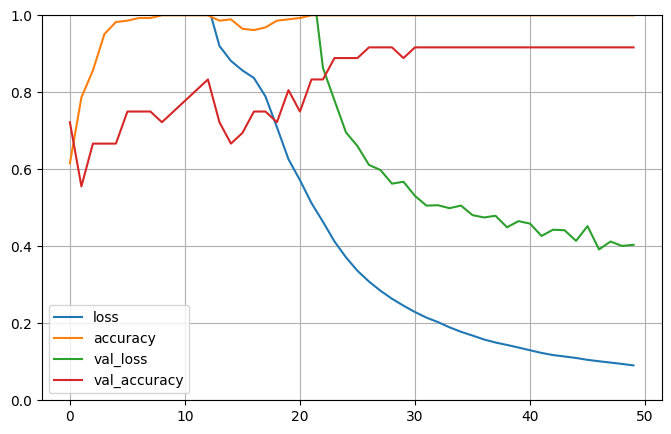

In [325]:
# Crea il modello
model = keras.models.Sequential([
    keras.layers.Dense(150, activation="tanh", input_shape=[len(union_mrmr)],
                 kernel_regularizer=keras.regularizers.l1(0.001)),
    keras.layers.Dense(50, activation="tanh", kernel_regularizer=keras.regularizers.l1(0.001)),
    keras.layers.Dense(2, activation="sigmoid")
])

# Compila il modello, includendo i pesi delle classi
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=keras.optimizers.Adam(0.002),
              metrics=["accuracy"])

# Stampa un sommario del modello
model.summary()

# Addestra il modello, includendo i pesi delle classi
history = model.fit(X_train, y_train, epochs=50, validation_data=(X_val, y_val), class_weight=class_weight_dict)

# Valuta il modello
model.evaluate(X_val, y_val)

# Plot delle curve di apprendimento
import pandas as pd
import matplotlib.pyplot as plt

pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1)
plt.show()


In [326]:
y_pred = model.predict(X_val)
y_pred = np.argmax(y_pred, axis=1)

2/2 [==============================] - 0s 2ms/step


In [327]:
print(confusion_matrix(y_val, y_pred))
print(classification_report(y_val, y_pred))

[[30  2]
 [ 1  3]]
              precision    recall  f1-score   support

           0       0.97      0.94      0.95        32
           1       0.60      0.75      0.67         4

    accuracy                           0.92        36
   macro avg       0.78      0.84      0.81        36
weighted avg       0.93      0.92      0.92        36



## Genetic NN

In [ ]:
selected_features_genetic = ['1007_s_at', '121_at', '1255_g_at', '1294_at', '1316_at', '1320_at','1431_at',
 '1552256_a_at', '1552258_at', '1552263_at', '1552264_a_at', '1552266_at',
 '1552271_at', '1552272_a_at', '1552274_at', '1552275_s_at', '1552276_a_at',
 '1552277_a_at', '1552278_a_at', '1552286_at', '1552287_s_at', '1552288_at',
 '1552293_at', '1552295_a_at', '1552296_at', '1552299_at', '1552301_a_at',
 '1552304_at', '1552306_at', '1552307_a_at', '1552311_a_at', '1552312_a_at',
 '1552314_a_at', '1552315_at', '1552316_a_at', '1552319_a_at', '1552320_a_at',
 '1552322_at', '1552325_at', '1552327_at', '1552330_at', '1552332_at',
 '1552337_s_at', '1552340_at', '1552343_s_at', '1552344_s_at', '1552348_at']

In [249]:
reset_data()
X_train, X_val = X_train[selected_features_genetic], X_val[selected_features_genetic]


Model: "sequential_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_43 (Dense)            (None, 146)               7008      
                                                                 
 dropout_7 (Dropout)         (None, 146)               0         
                                                                 
 dense_44 (Dense)            (None, 25)                3675      
                                                                 
 dense_45 (Dense)            (None, 2)                 52        
                                                                 
Total params: 10735 (41.93 KB)
Trainable params: 10735 (41.93 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/100
9/9 [==============================] - 0s 16ms/step - loss: 10.3741 - accuracy: 0.2378 - val_loss: 9.8358 - val_accuracy: 0.3611
Epoch 2/

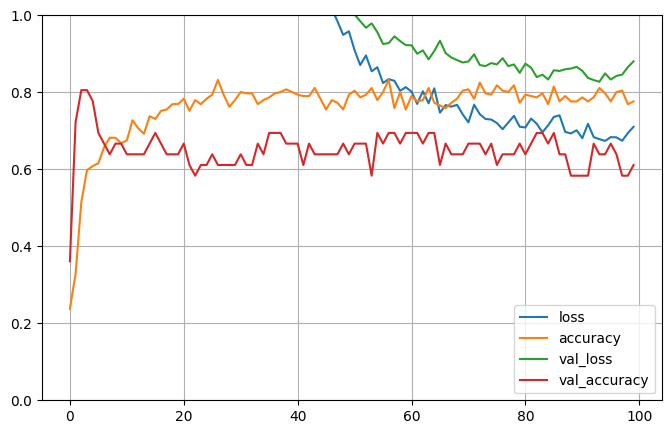

In [250]:
# Crea il modello
model = keras.models.Sequential([
    keras.layers.Dense(146, activation="relu", input_shape=[len(selected_features_genetic)],
                 kernel_regularizer=keras.regularizers.l1(0.01)),
    keras.layers.Dropout(0.7),
    keras.layers.Dense(25, activation="relu", kernel_regularizer=keras.regularizers.l1(0.01)),
    keras.layers.Dense(2, activation="sigmoid")
])

# Compila il modello, includendo i pesi delle classi
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=keras.optimizers.Adam(0.001),
              metrics=["accuracy"])

# Stampa un sommario del modello
model.summary()

# Addestra il modello, includendo i pesi delle classi
history = model.fit(X_train, y_train, epochs=100, validation_data=(X_val, y_val), class_weight=class_weight_dict)

# Valuta il modello
model.evaluate(X_val, y_val)

# Plot delle curve di apprendimento
import pandas as pd
import matplotlib.pyplot as plt

pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1)
plt.show()


In [251]:
y_pred = model.predict(X_val)
y_pred = np.argmax(y_pred, axis=1)

2/2 [==============================] - 0s 4ms/step


In [252]:
print(confusion_matrix(y_val, y_pred))
print(classification_report(y_val, y_pred))

[[21 11]
 [ 3  1]]
              precision    recall  f1-score   support

           0       0.88      0.66      0.75        32
           1       0.08      0.25      0.12         4

    accuracy                           0.61        36
   macro avg       0.48      0.45      0.44        36
weighted avg       0.79      0.61      0.68        36



## RFE and Genetic NN

In [253]:
rfe_genetic = rfe_union + selected_features_genetic

In [254]:
reset_data()
X_train, X_val = X_train[rfe_genetic], X_val[rfe_genetic]

Model: "sequential_24"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_73 (Dense)            (None, 146)               21608     
                                                                 
 dense_74 (Dense)            (None, 25)                3675      
                                                                 
 dense_75 (Dense)            (None, 2)                 52        
                                                                 
Total params: 25335 (98.96 KB)
Trainable params: 25335 (98.96 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/100
9/9 [==============================] - 0s 15ms/step - loss: 18.7378 - accuracy: 0.6818 - val_loss: 18.0687 - val_accuracy: 0.6111
Epoch 2/100
9/9 [==============================] - 0s 3ms/step - loss: 17.2105 - accuracy: 0.7937 - val_loss: 16.6426 - val_accuracy: 0.722

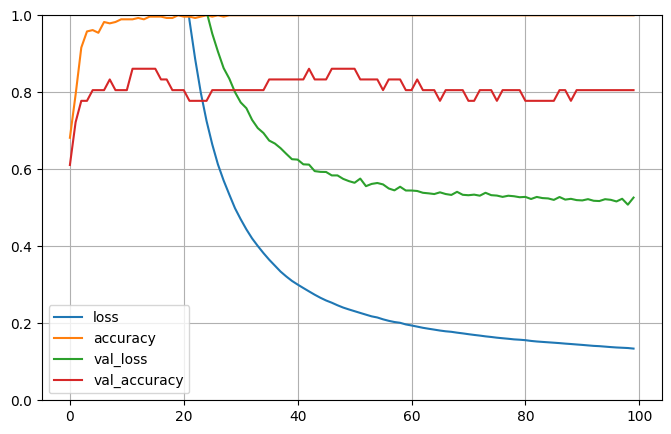

In [282]:
# Crea il modello
model = keras.models.Sequential([
    keras.layers.Dense(146, activation="relu", input_shape=[len(rfe_genetic)],
                 kernel_regularizer=keras.regularizers.l1(0.01)),
    keras.layers.Dense(25, activation="relu", kernel_regularizer=keras.regularizers.l1(0.01)),
    keras.layers.Dense(2, activation="sigmoid")
])

# Compila il modello, includendo i pesi delle classi
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=keras.optimizers.Adam(0.001),
              metrics=["accuracy"])

# Stampa un sommario del modello
model.summary()

# Addestra il modello, includendo i pesi delle classi
history = model.fit(X_train, y_train, epochs=100, validation_data=(X_val, y_val), class_weight=class_weight_dict)

# Valuta il modello
model.evaluate(X_val, y_val)

# Plot delle curve di apprendimento
import pandas as pd
import matplotlib.pyplot as plt

pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1)
plt.show()

In [283]:
y_pred = model.predict(X_val)
y_pred = np.argmax(y_pred, axis=1)

2/2 [==============================] - 0s 1ms/step


In [284]:
print(confusion_matrix(y_val, y_pred))
print(classification_report(y_val, y_pred))

[[28  4]
 [ 3  1]]
              precision    recall  f1-score   support

           0       0.90      0.88      0.89        32
           1       0.20      0.25      0.22         4

    accuracy                           0.81        36
   macro avg       0.55      0.56      0.56        36
weighted avg       0.83      0.81      0.81        36



####Trying with a NN

In [963]:
len(genetic_mrmr)

146

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_33 (Dense)            (None, 146)               21462     
                                                                 
 dropout_18 (Dropout)        (None, 146)               0         
                                                                 
 dense_34 (Dense)            (None, 25)                3675      
                                                                 
 dense_35 (Dense)            (None, 2)                 52        
                                                                 
Total params: 25189 (98.39 KB)
Trainable params: 25189 (98.39 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/100
11/11 [==============================] - 0s 12ms/step - loss: 19.3743 - accuracy: 0.8416 - val_loss: 17.7187 - val_accuracy: 0.8889
Epoch

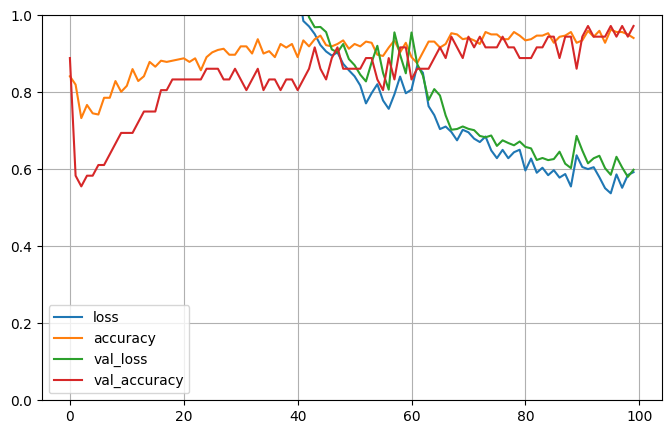

In [996]:
# Crea il modello
model = keras.models.Sequential([
    keras.layers.Dense(146, activation="relu", input_shape=[len(genetic_mrmr)],
                 kernel_regularizer=keras.regularizers.l1(0.01)),
    keras.layers.Dropout(0.7),
    keras.layers.Dense(25, activation="relu", kernel_regularizer=keras.regularizers.l1(0.01)),
    keras.layers.Dense(2, activation="sigmoid")
])

# Compila il modello, includendo i pesi delle classi
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=keras.optimizers.Adam(0.001),
              metrics=["accuracy"])

# Stampa un sommario del modello
model.summary()

# Addestra il modello, includendo i pesi delle classi
history = model.fit(X_train, y_train, epochs=100, validation_data=(X_val, y_val), class_weight=class_weight_dict)

# Valuta il modello
model.evaluate(X_val, y_val)

# Plot delle curve di apprendimento
import pandas as pd
import matplotlib.pyplot as plt

pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1)
plt.show()


In [997]:
y_pred = model.predict(X_val)
y_pred = np.argmax(y_pred, axis=1)

2/2 [==============================] - 0s 1ms/step


In [998]:
print(confusion_matrix(y_val, y_pred))
print(classification_report(y_val, y_pred))

[[31  1]
 [ 0  4]]
              precision    recall  f1-score   support

           0       1.00      0.97      0.98        32
           1       0.80      1.00      0.89         4

    accuracy                           0.97        36
   macro avg       0.90      0.98      0.94        36
weighted avg       0.98      0.97      0.97        36



In [1002]:
# Let's use Shap to explain MLP predictions
import shap

explainer = shap.DeepExplainer(model, X_val)

# Calculate SHAP values
shap_values = explainer.shap_values(X_val)

# Plot SHAP summary plot
shap.summary_plot(shap_values, X_val)

Your TensorFlow version is newer than 2.4.0 and so graph support has been removed in eager mode and some static graphs may not be supported. See PR #1483 for discussion.


AttributeError: Exception encountered when calling layer 'sequential_11' (type Sequential).

'tuple' object has no attribute 'rank'

Call arguments received by layer 'sequential_11' (type Sequential):
  • inputs=['     232970_at  1552322_at  232083_at  233855_at  232228_at  204894_s_at  \\\n310   1.002156    0.067716   0.353643   0.101507  -1.082884     0.111453   \n217   0.091417   -0.929238  -1.341550  -1.006184   0.058102    -0.826610   \n351  -0.461299    1.047343  -1.052702  -1.092578  -0.991399    -1.269732   \n235   0.998328    1.238669  -0.475027  -0.375083   0.077328     1.347089   \n251  -0.888321   -1.040033   0.420244  -0.578976   0.312033    -0.630239   \n58   -1.318129   -0.596167   0.868572   0.708051  -0.090578     0.007132   \n13    0.211961    0.218306  -0.408312  -0.117252  -0.639168     0.112295   \n91   -0.344479    0.224324   0.738170   0.803896  -0.908212    -1.049412   \n243  -0.393334    2.513342  -0.516261   0.133800   0.868339    -2.096357   \n50   -1.188285   -1.115359  -0.355747  -1.186305  -0.048495    -0.732786   \n263  -0.536600   -1.271580  -0.093374  -0.419655   0.138220     1.209355   \n20    0.686761    0.408253  -0.459618  -0.245062   0.261472     0.080683   \n71   -3.511570    2.167066   0.780928   0.123521   0.533133    -0.552144   \n241  -0.398396   -0.373023  -0.168364   0.304244  -1.113498    -0.819537   \n81   -1.053186    0.847705  -1.014374   0.518248   0.862042    -0.660523   \n205  -0.348617    0.028988   0.221700  -0.168168   0.604111     1.469774   \n1     1.251289   -0.204670   0.246021   0.541724   1.176965    -0.170179   \n21    1.785996   -0.648137  -0.123958   0.280346   1.603383     1.842301   \n53   -0.119034   -1.283462  -0.548213  -0.282334  -0.219546     0.158278   \n350  -1.114861    1.065389  -0.725611  -1.855783   1.854615    -0.577670   \n317   2.100339   -0.185548   0.634745  -0.147804  -0.170900    -0.263454   \n207   0.551128    0.816266  -0.035446  -0.334854   1.483957     0.264000   \n306   0.681944   -0.058342  -1.187044  -0.761423  -1.769202     0.369623   \n191   0.961189    0.392106   0.175703   0.303077   1.482627     0.359551   \n355   0.792546   -1.325213  -0.662313  -0.759218  -0.508680     0.311868   \n52   -0.013317   -0.771803  -0.197897  -0.160710   0.018175    -0.861963   \n99   -1.230192    0.657804  -0.640025   1.307476   1.543381    -0.358719   \n166   1.211806   -0.624703  -0.828038  -1.390872  -0.580661    -0.493748   \n259  -1.697463   -0.684369   1.402274   1.480956  -1.700924    -1.710242   \n134   0.509230   -0.368520   2.655619   0.876585  -0.831639    -0.282434   \n313   1.278056   -0.268638  -0.548994  -0.618382  -1.775099     1.001125   \n80   -0.242938   -0.641472   0.322260  -0.539029  -1.143446    -0.068510   \n34    0.070043   -0.262642  -0.873993   1.245698  -0.187668     0.564248   \n341   0.073914   -1.590580   0.418647  -0.673696   0.262524    -0.764797   \n188   0.658907    0.987518  -0.972815   0.392121   0.190993    -0.337552   \n264   0.312302    0.430518  -0.877107  -0.169946   1.307524    -1.058097   \n\n     224650_at  1552287_s_at  205489_at  206595_at  ...  1552278_a_at  \\\n310  -0.161140      0.461580   0.876798   0.143301  ...      0.132369   \n217  -0.452649      1.331601   0.205649  -0.915539  ...     -1.628747   \n351  -0.083587      0.544428  -1.050157  -0.737143  ...     -0.171051   \n235  -0.159785     -0.049184   1.264699  -0.161682  ...      0.715615   \n251  -0.389992      1.079926  -0.161773   1.705882  ...     -0.860955   \n58   -0.525391     -1.446440  -0.428017   0.002023  ...      0.949277   \n13   -0.399195     -1.488314   0.655494   0.321146  ...      0.483847   \n91   -0.041221     -0.783394  -0.159899  -0.803745  ...      0.888426   \n243  -0.447640      1.047717  -0.931390  -0.577636  ...     -1.712623   \n50    0.321502     -0.373774  -0.874195   0.457439  ...     -1.489893   \n263  -0.768102      1.581743  -1.061660  -0.427002  ...     -0.130376   \n20   -0.326221     -0.979305   0.440591  -0.825551  ...      0.125808   \n71    1.528556     -1.069692   0.100939  -1.196764  ...     -0.402230   \n241   0.058705      0.445781  -0.643086   0.632841  ...     -0.336944   \n81   -0.385462     -1.316369  -0.344249  -1.088026  ...     -0.845076   \n205  -0.360591      0.077437  -1.894392   0.402536  ...     -0.320610   \n1    -0.247499     -1.184192   1.221916  -1.438973  ...      0.238756   \n21   -0.350165     -0.923777  -0.173825  -0.121979  ...      2.364231   \n53   -0.554046     -0.265627   0.052784  -0.496676  ...     -0.435709   \n350  -0.500062      1.498572  -1.349357  -1.049655  ...     -1.946176   \n317  -0.251930     -2.101086  -0.016879  -0.237764  ...     -1.220546   \n207  -0.302765      0.795387   0.423115  -0.234909  ...      0.233323   \n306   4.720333      1.096025   0.373092   0.738844  ...      0.138655   \n191  -0.266166     -0.369629  -0.417822  -0.085596  ...     -0.471003   \n355  -0.532011      0.139950  -0.873416   0.389140  ...      0.156887   \n52   -0.265434     -0.010122  -0.660099  -1.444535  ...      0.022067   \n99    0.037569     -0.331918   0.170133   0.023435  ...     -1.843802   \n166  -0.168545      1.040352   0.091528   0.299809  ...      1.111303   \n259  -0.147768      1.350562  -2.049357   0.222183  ...      1.687359   \n134   0.286671     -0.186025  -0.998185   1.629522  ...      1.055405   \n313   1.928621      0.904784   0.031223   1.412717  ...      0.260946   \n80   -0.075270     -1.644829  -1.097399  -1.112411  ...     -0.692379   \n34   -0.523539     -0.418642   1.369217  -0.088263  ...      0.012599   \n341   4.577892     -0.323526  -0.386964   1.725204  ...     -1.493144   \n188  -0.537442      0.186014   1.782387  -0.461884  ...      0.691035   \n264  -0.554913      1.135187  -0.812645  -0.532800  ...     -0.477629   \n\n     1562821_a_at  242881_x_at  231614_at  1567559_s_at  239336_at  239664_at  \\\n310      0.021751    -0.533337   0.120129      0.590334   0.807828   1.228210   \n217     -1.880509     0.461715  -0.870781     -0.430853  -0.194059  -1.745855   \n351     -0.767744    -0.413328  -0.575889     -0.000868  -0.037152  -0.765866   \n235     -0.397323    -0.853204  -0.625110     -0.861212   1.123664  -0.111693   \n251     -0.503145     1.946184  -1.215118     -0.497516   0.271889  -1.373580   \n58       0.119786    -0.248189   0.830560     -0.631563  -1.147311  -0.454366   \n13       0.171091    -0.409831   1.599894      0.107453  -0.621664  -0.821661   \n91       1.071694     0.382007   1.539960      0.900666  -0.322279  -0.055856   \n243     -1.267246     3.092568  -1.344234      1.487853  -1.137447  -0.568748   \n50       0.976907     0.433032  -0.860803      0.129432  -1.316736  -0.025315   \n263     -0.879785    -0.457098   1.085263     -0.949200   0.319285  -0.163205   \n20       0.509513    -0.675237   0.452343      0.349799  -0.115232  -1.186652   \n71       1.086264     1.117042   0.621678     -0.734794   0.021376   1.782424   \n241      0.131700     0.342719  -0.511663     -0.109718   0.308569  -0.472103   \n81       0.511859    -0.778723  -0.113861     -0.371699   0.555044  -1.154840   \n205     -0.938287     0.758423  -0.756800      0.005976  -0.367454  -0.640752   \n1        2.792413    -0.236902   0.926110      0.947897  -0.368126  -1.068916   \n21       0.099677    -0.776745  -0.505473     -0.407018   1.664336  -0.875161   \n53      -0.113632    -0.474622  -0.452393     -0.336704  -0.017677  -1.341421   \n350     -1.038380    -0.603927  -0.281340      0.136330  -1.181378  -0.259952   \n317     -0.541189    -0.893997   0.681827     -0.096099   0.648568   1.791224   \n207     -0.929737    -0.169694   0.724078     -0.284958   1.826028   1.871438   \n306     -0.896849     2.104228   0.952080      1.457693   0.776393  -0.187202   \n191     -0.465407    -0.342312  -0.147381     -0.741888   3.340202  -0.087697   \n355     -0.472523    -0.235528  -0.839249     -1.081808   0.159801  -0.473357   \n52       0.526435     0.947867   0.255879     -1.966546  -1.272381  -0.261302   \n99       2.044438    -0.864736   1.282746     -1.331465  -0.353935   1.461386   \n166     -0.632154     0.049464   0.260850      0.959206  -1.219044  -0.732750   \n259     -0.135535    -0.248289   0.927485     -0.125923  -0.173485  -0.113390   \n134     -0.582373     0.918991   1.215596     -0.193598  -0.762966  -0.713333   \n313      0.037365    -0.664164   0.118040      0.428809   2.095804   1.923974   \n80      -0.126903     1.230044   2.104380     -0.725381  -0.471621  -0.509778   \n34      -0.130921    -1.174272  -0.919451      0.321583  -0.199547  -0.540915   \n341      0.035486     0.467162  -0.155397     -0.366532   1.475853  -1.374965   \n188     -0.148269    -0.500896  -1.348893      1.209336   0.151114   0.324372   \n264     -0.554565    -0.915691   0.025459     -0.222165  -0.055672   0.065556   \n\n     1552314_a_at  1552286_at  215311_at  \n310     -0.429718   -0.608906  -1.026268  \n217     -1.469568    0.022295  -0.204968  \n351      0.216237   -1.039053  -0.621281  \n235      1.533365   -0.016195  -0.821674  \n251     -0.343805    0.578226  -0.719807  \n58       0.404349    0.303806   0.482455  \n13      -0.705257   -0.201163   0.234944  \n91       0.056641   -1.022344   0.571268  \n243     -0.371100   -0.616812  -0.604014  \n50      -1.441840   -0.670653   0.546961  \n263      2.910826    1.189264  -0.880270  \n20      -0.396487   -0.340057   0.276033  \n71      -1.095646   -1.590773  -0.771780  \n241      2.049490    0.563175   0.033059  \n81       0.024919   -2.412830   0.800910  \n205     -0.191229   -0.510459  -0.580740  \n1       -0.363127   -0.775523   0.140807  \n21       1.095428   -0.539949  -0.120884  \n53       0.535698   -0.612817  -0.248001  \n350      0.134595    2.699302  -0.798662  \n317     -0.053197   -2.041584  -0.658459  \n207      0.885705   -0.680880  -0.149786  \n306      0.795604    0.616405  -0.887935  \n191     -0.558140   -0.164398  -0.700849  \n355      1.979722   -1.225606   0.065578  \n52      -0.142365    0.113263   1.172011  \n99      -0.369400   -0.014200  -0.128241  \n166      0.434824   -0.240700  -0.476027  \n259     -0.593766    1.311060  -0.306411  \n134     -0.263406    0.381274   0.732845  \n313      1.710005   -0.024915  -0.456826  \n80      -1.306723   -1.639115   1.911601  \n34      -0.867372    0.164088  -0.249808  \n341      0.012181    0.593574  -0.111368  \n188     -1.023563   -0.467744   1.301347  \n264     -0.214117    0.489568  -0.110796  \n\n[36 rows x 146 columns]']
  • training=None
  • mask=None

# Combining selection methods

In [777]:
with open ('mrmr_300_unbiased.txt') as f:
    corr_features = f.read().splitlines()

In [783]:
miq_features = list(X.columns[features_mrmr])

In [785]:
union = set(corr_features).union(set(miq_features))

In [786]:
len(union)

499

In [789]:
reset_data()

In[43]:

In [ ]:
from sklearn.model_selection import train_test_split
X_train_selected = X_train[mrmr_selected]
X_val_selected = X_val[mrmr_selected]
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix

Initializing the decision tree classifier

In [ ]:
clf = DecisionTreeClassifier(random_state=42)
# Training the classifier
clf.fit(X_train_selected, y_train)

Making predictions on the validation set

In [ ]:
y_pred_validation = clf.predict(X_val_selected)

Evaluating the model

In [ ]:
print("Validation Set Performance:")
print(classification_report(y_val, y_pred_validation))
print(confusion_matrix(y_val, y_pred_validation))

In[50]:

Trying with a SVM

In [ ]:
from sklearn.svm import SVC

In [ ]:
clf = SVC(kernel='linear', C=0.1)
clf.fit(X_train_selected, y_train)

In [ ]:
y_pred_validation = clf.predict(X_val_selected)

In [ ]:
print(classification_report(y_val, y_pred_validation))
print(confusion_matrix(y_val, y_pred_validation))

# 36 geni ricercatori

In[51]:

In [793]:
X_train_researchers = X_train[prob_genes]
X_validation_researchers = X_val[prob_genes]

NameError: name 'prob_genes' is not defined

Initializing the decision tree classifier

In [ ]:
clf = DecisionTreeClassifier(random_state=42)
# Training the classifier
clf.fit(X_train_researchers, y_train)

Making predictions on the validation set

In [ ]:
y_pred_validation = clf.predict(X_validation_researchers)

Evaluating the model

In [ ]:
print("Validation Set Performance:")
print(classification_report(y_val, y_pred_validation))

In[52]:

In [ ]:
from sklearn.metrics import confusion_matrix

In [ ]:
print(confusion_matrix(y_val, y_pred_validation))

In[53]:

In [ ]:
from sklearn.svm import SVC

In [ ]:
clf = SVC(kernel='linear', C=1)
clf.fit(X_train_researchers, y_train)

In [ ]:
y_pred_validation = clf.predict(X_validation_researchers)

In [ ]:
print(classification_report(y_val, y_pred_validation))
print(confusion_matrix(y_val, y_pred_validation))

In [328]:
union_mrmr

['216829_at',
 '1556284_at',
 '1559433_at',
 '202389_s_at',
 '229491_at',
 '216573_at',
 '234419_x_at',
 '218199_s_at',
 '226882_x_at',
 '225822_at',
 '1565282_at',
 '1564130_x_at',
 '222457_s_at',
 '217320_at',
 '217145_at',
 '204153_s_at',
 '225846_at',
 '217235_x_at',
 '231131_at',
 '217360_x_at',
 '234366_x_at',
 '216560_x_at',
 '220169_at',
 '217084_at',
 '208528_x_at',
 '203695_s_at',
 '216412_x_at',
 '233624_at',
 '233255_s_at',
 '226481_at',
 '211648_at',
 '225825_at',
 '216542_x_at',
 '238444_at',
 '234884_x_at',
 '202207_at',
 '234094_x_at',
 '241400_at',
 '217148_x_at',
 '204065_at',
 '211908_x_at',
 '91580_at',
 '222761_at',
 '224348_s_at',
 '214777_at',
 '201030_x_at',
 '240163_at',
 '1561937_x_at',
 '210538_s_at',
 '238498_at',
 '211655_at',
 '208688_x_at',
 '1565535_x_at',
 '1552299_at',
 '217892_s_at',
 '238052_at',
 '216557_x_at',
 '202644_s_at',
 '202246_s_at',
 '217236_x_at',
 '204047_s_at',
 '223417_at',
 '1554807_a_at',
 '234764_x_at',
 '220066_at',
 '227648_at',
 

# IGNOREME

## Apply RFE (SVC selector) to mrmr features

In[54]:

In [ ]:
MRMR = True
STATISTICAL = False

In[55]:

In [ ]:
if STATISTICAL: 
    with open ('statistical-tests/union.csv') as f:
        selected_features = f.read().splitlines()
if MRMR:
    with open ('mrmr_300_unbiased.txt') as f:
        selected_features = f.read().splitlines()

In[56]:

In [ ]:
X_train_selected = X_train[selected_features]
X_val_selected = X_val[selected_features]

In[57]:

Apply RFE to selected features with SVR as estimator

In [ ]:
from sklearn.feature_selection import RFE

In[58]:

In [ ]:
selector_svc = RFE(estimator=SVC(kernel='linear', C=1), n_features_to_select=50, step=1)
selector_svc = selector_svc.fit(X_train_selected, y_train)

In[59]:

Show selected features and results of classification based on them

In [ ]:
svc_selected_features_mask = selector_svc.support_

Get the names or indices of the selected features

In [ ]:
svc_selected_features_mask = selector_svc.support_
svc_selected_features_indices = [i for i, selected in enumerate(svc_selected_features_mask) if selected]
svc_selected_features_rfe = [selected_features[i] for i in svc_selected_features_indices]

In[60]:

In [ ]:
with open("mrmr_rfe_svc.txt", "w") as file:
    # Write each gene to the file
    for gene in svc_selected_features_rfe:
        file.write(gene + "\n")

In[61]:

Reading genes from mrmr_features.txt lines

In [ ]:
with open('mrmr_rfe_svc.txt', 'r') as f:
    svc_selected_features_rfe = [line.strip() for line in f.readlines()]

In[62]:

Implement SVC with new selected features

In [ ]:
clf = SVC(kernel='linear', C = 3)
clf.fit(X_train[svc_selected_features_rfe], y_train)
y_pred_validation = clf.predict(X_val[svc_selected_features_rfe])

In [ ]:
print(classification_report(y_val, y_pred_validation))
print(confusion_matrix(y_val, y_pred_validation))

In[63]:

In [ ]:
clf = DecisionTreeClassifier(random_state=42)
# Training the classifier
clf.fit(X_train_selected, y_train)

Making predictions on the validation set

In [ ]:
y_pred_validation = clf.predict(X_val_selected)

Evaluating the model

In [ ]:
print("Validation Set Performance:")
print(classification_report(y_val, y_pred_validation))
print(confusion_matrix(y_val, y_pred_validation))

In[65]:

In [ ]:
from sklearn.neural_network import MLPClassifier

In [ ]:
clf = MLPClassifier(hidden_layer_sizes=(50, 15), max_iter=1000)
clf.fit(X_train[svc_selected_features_rfe], y_train)
y_pred_val = clf.predict(X_val[svc_selected_features_rfe])
print(classification_report(y_val, y_pred_val))

In[66]:

In [ ]:
y_val.value_counts()

## Apply RFE (LogReg selector) to mrmr features

In[67]:

In [ ]:
selector_logreg = RFE(estimator=LogisticRegression(), n_features_to_select=80, step=1)
selector_logreg = selector_svc.fit(X_train_selected, y_train)

In[68]:

Show selected features and results of classification based on them

In [ ]:
logreg_selected_features_mask = selector_logreg.support_

Get the names or indices of the selected features

In [ ]:
logreg_selected_features_indices = [i for i, selected in enumerate(logreg_selected_features_mask) if selected]
logreg_selected_features_rfe = [selected_features[i] for i in logreg_selected_features_indices]

In [ ]:
clf = LogisticRegression()
clf.fit(X_train[logreg_selected_features_rfe], y_train)
y_pred_validation = clf.predict(X_val[logreg_selected_features_rfe])

In [ ]:
print(classification_report(y_val, y_pred_validation))
print(confusion_matrix(y_val, y_pred_validation))

In[69]:

In [ ]:
clf = SVC(kernel='linear', C = 0.4)
clf.fit(X_train[logreg_selected_features_rfe], y_train)
y_pred_validation = clf.predict(X_val[logreg_selected_features_rfe])

In [ ]:
print(classification_report(y_val, y_pred_validation))
print(confusion_matrix(y_val, y_pred_validation))

## Apply RFE (Random Forest) to mrmr features

In[59]:

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import RFE
from sklearn.datasets import make_classification

In [ ]:
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)
# Crea un selettore di feature RFE utilizzando il classificatore Random Forest
rfe_selector = RFE(estimator=rf_classifier, n_features_to_select= 80, step=1)

Addestra il selettore di feature sul set di dati

In [ ]:
rfe_selector.fit(X_train_selected, y_resampled)

In[60]:

In [ ]:
rf_selected_features_mask = rfe_selector.support_

Get the names or indices of the selected features

In [ ]:
rf_selected_features_indices = [i for i, selected in enumerate(rf_selected_features_mask) if selected]
rf_selected_features_rfe = [selected_features[i] for i in rf_selected_features_indices]

In[61]:

In [ ]:
clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train[rf_selected_features_rfe], y_train)
y_pred_validation = clf.predict(X_val[rf_selected_features_rfe])

In [ ]:
print(classification_report(y_val, y_pred_validation))
print(confusion_matrix(y_val, y_pred_validation))

None of the experiments significally outperformed the 36 gene set

In[ ]:

Creare un DataFrame per i coefficienti delle feature

In [ ]:
coef_df = pd.DataFrame({'Feature': log_reg_selected_features_rfe, 'Coefficient': clf.coef_[0]})

Ordinare il DataFrame per coefficienti

In [ ]:
coef_df = coef_df.sort_values(by='Coefficient', ascending=False)

Creare un grafico a barre dei coefficienti

In [ ]:
plt.figure(figsize=(10, 6))
plt.barh(coef_df['Feature'], coef_df['Coefficient'], color='skyblue')
plt.xlabel('Coefficient')
plt.ylabel('Feature')
plt.title('Coefficients of Features')
plt.grid(axis='x')
plt.show()

## Esplorazione features selezionate con mrmr e rfe

In[ ]:

In [ ]:
intersection = set(log_reg_selected_features_rfe).intersection(set(svc_selected_features_rfe))

In[ ]:

In [ ]:
len(intersection)

In[ ]:

In [ ]:
X = gene_expression_data[list(intersection)]
y = gene_expression_data['state']

In [ ]:
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.4, stratify=y, random_state=11)
X_validation, X_test, y_validation, y_test = train_test_split(X_temp, y_temp, test_size=0.5, stratify=y_temp, random_state=87)

In [ ]:
clf = SVC(kernel='linear', C = 100)
clf.fit(X, y)
y_pred_validation = clf.predict(X_validation)

In [ ]:
print(classification_report(y_validation, y_pred_validation))
print(confusion_matrix(y_validation, y_pred_validation))

In[ ]:

In [ ]:
with open('probe_genes.txt', 'r') as f:
    probe_genes = f.read().split('\n')

In[ ]:

In [ ]:
intersection_probe = set(probe_genes).intersection(set(svc_selected_features_rfe))

In[ ]:

In [ ]:
len(intersection_probe)

## Features estrette con svc

In[ ]:

In [ ]:
X = gene_expression_data[svc_selected_features_rfe]

In[ ]:

In [ ]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns

Esegui la PCA

In [ ]:
pca = PCA(n_components=10)  # Scegli il numero di componenti principali da mantenere
X_pca = pca.fit_transform(X)  # X è il tuo dataset di features

Aggiungi la label target come colore per la visualizzazione

In [ ]:
plt.figure(figsize=(10, 8))
sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], hue=y, palette='viridis')
plt.title('PCA plot')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend(title='Target Label')
plt.show()

In[ ]:

Get correlation heatmap

In [ ]:
corr_0 = X.corr()
plt.figure(figsize=(12, 10))
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f", annot_kws={"size": 7})
plt.title('Heatmap di correlazione')
plt.show()

In[ ]:

In [ ]:
X['state'] = y
X_sani, X_malati  = X[X['state']==0], X[X['state']==1]
all_records = X.drop(columns=['state']).values
records_sani = X_sani.drop(columns=['state']).values
records_malati  = X_malati.drop(columns=['state']).values

In[ ]:

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
def plot_comparison(features_group1, features_group2, feature_names):
    num_features = len(feature_names)
    fig, axs = plt.subplots(num_features, 2, figsize=(24, 6*num_features))
    for i in range(num_features):
        # Boxplot
        axs[i, 0].boxplot([features_group1[:, i], features_group2[:, i]], labels=['Group 1', 'Group 2'])
        axs[i, 0].set_title(feature_names[i] + ' - Boxplot')

        # Kernel Density Estimation (KDE) Plot
        sns.kdeplot(features_group1[:, i], ax=axs[i, 1], label='Group 1', color='blue')
        sns.kdeplot(features_group2[:, i], ax=axs[i, 1], label='Group 2', color='orange')
        axs[i, 1].set_title(feature_names[i] + ' - KDE Plot')
        axs[i, 1].legend()
    plt.tight_layout()
    plt.show()

Visualizzazione e confronto delle features

In [ ]:
plot_comparison(records_sani, records_malati, svc_selected_features_rfe)
 

In[ ]:

 Features estrette con log reg

In [ ]:
X = gene_expression_data[log_reg_selected_features_rfe]
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns

Esegui la PCA

In [ ]:
pca = PCA(n_components=10)  # Scegli il numero di componenti principali da mantenere
X_pca = pca.fit_transform(X)  # X è il tuo dataset di features

Aggiungi la label target come colore per la visualizzazione

In [ ]:
plt.figure(figsize=(10, 8))
sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], hue=y, palette='viridis')
plt.title('PCA plot')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend(title='Target Label')
plt.show()

Get correlation heatmap

In [ ]:
corr_0 = X.corr()
plt.figure(figsize=(12, 10))
sns.heatmap(corr_0, annot=True, cmap='coolwarm', fmt=".2f", annot_kws={"size": 7})
plt.title('Heatmap di correlazione')
plt.show()
X['state'] = y
X_sani, X_malati  = X[X['state']==0], X[X['state']==1]
all_records = X.drop(columns=['state']).values
records_sani = X_sani.drop(columns=['state']).values
records_malati  = X_malati.drop(columns=['state']).values
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
def plot_comparison(features_group1, features_group2, feature_names):
    num_features = len(feature_names)
    fig, axs = plt.subplots(num_features, 2, figsize=(24, 6*num_features))
    for i in range(num_features):
        # Boxplot
        axs[i, 0].boxplot([features_group1[:, i], features_group2[:, i]], labels=['Group 1', 'Group 2'])
        axs[i, 0].set_title(feature_names[i] + ' - Boxplot')

        # Kernel Density Estimation (KDE) Plot
        sns.kdeplot(features_group1[:, i], ax=axs[i, 1], label='Group 1', color='blue')
        sns.kdeplot(features_group2[:, i], ax=axs[i, 1], label='Group 2', color='orange')
        axs[i, 1].set_title(feature_names[i] + ' - KDE Plot')
        axs[i, 1].legend()
    plt.tight_layout()
    plt.show()

Visualizzazione e confronto delle features

In [ ]:
plot_comparison(records_sani, records_malati, log_reg_selected_features_rfe)
 

In[ ]:

In [ ]:
with open('statistical-tests/intersection.txt', 'rb') as f:
    statistical_selected = [line.strip() for line in f.readlines()]

In[15]:

STEP 1: at this step we try different combination of features selection

In [ ]:
STEP_1 = [mrmr_selected, statistical_selected]
# STEP 2: anothed ft selecteion step with different methods
# Questa lista contiene istanze di RFE basato su Log Reg, Lasso, SVM, ABC e GA basati su fitness
# implementata per dataset sbilanciati, fitness basata su purezza cluster e fitness basata su F1. 
STEP_2 = []
# STEP 3: we try different classifiers with different hyper parameters: SVM, Random Forest, Lasso, Elastic Net

## mrmr with customized normalization

P. A. Mundra and J. C. Rajapakse, "SVM-RFE With MRMR Filter for Gene Selection," in IEEE Transactions on NanoBioscience, vol. 9, no. 1, pp. 31-37, March 2010, doi: 10.1109/TNB.2009.2035284

In[ ]:

In [ ]:
def custom_normalization(x, mean, std):
    if x > mean + 0.5 * std:
        return 2
    elif x < mean - 0.5 * std:
        return -2
    else:
        return 0

Calcoliamo la media e la deviazione standard dei dati

In [ ]:
mean = df.mean()
std = df.std()

Applichiamo la normalizzazione al DataFrame

In [ ]:
df_normalized = df.apply(lambda x: custom_normalization(x, mean, std))

In [ ]:
print(df_normalized)